In [2]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module=r".*sklearn\.utils\.extmath")


# Minimal Bayesian Hyperparameter Optimization for 6-Loop Intra-Loop Experiment
# =============================================================================
# Based on your existing intra-loop code structure

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Install scikit-optimize if not available
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
except ImportError:
    print("Installing scikit-optimize...")
    import subprocess
    subprocess.check_call(["pip", "install", "scikit-optimize"])
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args


import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args


In [ ]:
import pandas as pd


dfs = []

for i in [5,6,7,8,9,10,11]:
    df = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
    df['loops'] = i
    dfs.append(df)

In [50]:
# Add this small helper near the top of your script (or inside the function)
def _json_safe(o):
    if isinstance(o, (np.int32, np.int64)):
        return int(o)
    elif isinstance(o, (np.float32, np.float64)):
        return float(o)
    elif isinstance(o, (np.ndarray,)):
        return o.tolist()
    else:
        raise TypeError(f"Object of type {type(o).__name__} is not JSON serializable")


def intra_bayesian_optimization(
    dfs,
    loop,
    *,
    n_calls=20,
    n_splits=5,
    n_workers=1,                 # <— parallel workers (fold-level & XGB)
    results_dir="bayes_results", # <— base folder to save all artifacts
    save_plot=True,
    random_state=42
):
    """
    Improved: parallel CV, parallel XGBoost training, and persistent results.

    Files created (under {results_dir}/{timestamp}/):
      - summary.json  : best params/scores, CV AUCs, config, paths
      - history.csv   : per-iteration params and CV score from gp_minimize
      - thresholds.csv: threshold grid with mean precision/recall/F1/balAcc
      - metrics.png   : (optional) thresholds plot
    """

    # =============================================================================
    # SETUP: data
    # =============================================================================
    data = dfs[dfs['loops'] == loop]
    print(f"Data shape: {data.shape}")
    data_cols = [c for c in data.columns
                 if 'COEFFICIENTS' not in c and 'loop' not in c]
    target_col = 'COEFFICIENTS'
    X = data[data_cols].values
    y = data[target_col].values.ravel()

    print(f"Features: {len(data_cols)}")
    print(f"Target distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

    # Results directory (timestamped)
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = Path(results_dir) / f"loop{loop}_{ts}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # =============================================================================
    # BAYESIAN OPTIMIZATION SPACE
    # =============================================================================
    dimensions = [
        Integer(50, 1000, name='n_estimators'),
        Integer(3, 20, name='max_depth'),
        Real(0.01, 0.3, name='learning_rate'),
        Real(0.6, 1.0, name='subsample'),
        Real(0.6, 1.0, name='colsample_bytree'),
        Real(0.0, 10.0, name='reg_alpha'),
        Real(0.0, 10.0, name='reg_lambda'),
    ]

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Helper: one fold training/eval (so we can parallelize)
    def _fit_eval_fold(train_idx, test_idx, params):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

        model = XGBClassifier(
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=n_workers,   # XGBoost parallelism within each fit
            **params
        )
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_scores)

    # Track optimization history in memory (we’ll also save to CSV)
    history_rows = []

    @use_named_args(dimensions=dimensions)
    def objective(**params):
        try:
            # Parallelize across CV folds
            fold_aucs = Parallel(n_jobs=n_workers, prefer="threads")(
                delayed(_fit_eval_fold)(train_idx, test_idx, params)
                for train_idx, test_idx in kf.split(X, y)
            )
            mean_auc = float(np.mean(fold_aucs))
            std_auc = float(np.std(fold_aucs))
            print(f"CV Score: {mean_auc:.3f} ± {std_auc:.3f} | Params: {params}")

            # Append to history
            history_rows.append({
                **params,
                "mean_auc": mean_auc,
                "std_auc": std_auc,
                "timestamp": time.time()
            })

            # Minimize => return negative AUC
            return -mean_auc

        except Exception as e:
            print(f"Error with params {params}: {e}")
            history_rows.append({**params, "mean_auc": np.nan, "std_auc": np.nan,
                                 "error": str(e), "timestamp": time.time()})
            return 1.0

    # =============================================================================
    # RUN BAYESIAN OPTIMIZATION
    # =============================================================================
    print("\n" + "="*60)
    print("Starting Bayesian Hyperparameter Optimization")
    print("="*60)

    result = gp_minimize(
        func=objective,
        dimensions=dimensions,
        n_calls=n_calls,
        random_state=random_state,
        acq_func='EI'
    )

    # Save optimization history CSV
    hist_df = pd.DataFrame(history_rows)
    hist_path = run_dir / "history.csv"
    hist_df.to_csv(hist_path, index=False)

    # =============================================================================
    # RESULTS
    # =============================================================================
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS")
    print("="*60)

    best_params = dict(zip([d.name for d in dimensions], result.x))
    best_score = float(-result.fun)
    print(f"Best CV Score: {best_score:.4f}")
    print("Best Parameters:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    # =============================================================================
    # FINAL EVALUATION WITH BEST PARAMETERS (parallelized)
    # =============================================================================
    print("\n" + "="*60)
    print("FINAL EVALUATION WITH BEST PARAMETERS")
    print("="*60)

    thresholds = np.linspace(0.01, 0.99, 99)
    precisions = np.zeros_like(thresholds, dtype=float)
    recalls = np.zeros_like(thresholds, dtype=float)
    f1s = np.zeros_like(thresholds, dtype=float)
    balanced_accuracies = np.zeros_like(thresholds, dtype=float)

    # Evaluate folds in parallel to collect scores for threshold sweep
    def _scores_for_fold(train_idx, test_idx):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

        model = XGBClassifier(
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=n_workers,
            **best_params
        )
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_scores)
        return y_test, y_scores, auc

    fold_results = Parallel(n_jobs=n_workers, prefer="threads")(
        delayed(_scores_for_fold)(train_idx, test_idx)
        for train_idx, test_idx in kf.split(X, y)
    )

    roc_aucs = []
    for fold, (y_test, y_scores, auc) in enumerate(fold_results, start=1):
        roc_aucs.append(auc)
        print(f"Fold {fold} ROC AUC: {auc:.3f}")

        for i, t in enumerate(thresholds):
            y_pred = (y_scores >= t).astype(int)
            precisions[i] += precision_score(y_test, y_pred, zero_division=0)
            recalls[i]    += recall_score(y_test, y_pred)
            f1s[i]        += f1_score(y_test, y_pred)
            balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

    n_folds = kf.get_n_splits()
    precisions /= n_folds
    recalls    /= n_folds
    f1s        /= n_folds
    balanced_accuracies /= n_folds

    mean_auc = float(np.mean(roc_aucs))
    std_auc  = float(np.std(roc_aucs))
    print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

    # Save threshold sweep CSV
    thr_df = pd.DataFrame({
        "threshold": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": balanced_accuracies
    })
    thr_path = run_dir / "thresholds.csv"
    thr_df.to_csv(thr_path, index=False)

    # Plot & save
    plot_path = None
    if save_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, precisions, label="Precision")
        plt.plot(thresholds, recalls, label="Recall")
        plt.plot(thresholds, f1s, label="F1 Score")
        plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
        plt.xlabel("Threshold")
        plt.ylabel("Metric Score")
        plt.title(f"Cross-Validated Metrics vs. Threshold (Optimized)\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plot_path = run_dir / "metrics.png"
        plt.savefig(plot_path, dpi=160)
        plt.close()

    # =============================================================================
    # SUMMARY + SAVE
    # =============================================================================
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"✓ Bayesian optimization completed with {len(result.func_vals)} iterations")
    print(f"✓ Best CV score: {best_score:.4f}")
    print(f"Artifacts saved to: {run_dir.resolve()}")

    summary = {
        "loop": int(loop),
        "timestamp": ts,
        "n_calls": int(n_calls),
        "n_splits": int(n_splits),
        "n_workers": int(n_workers),
        "random_state": int(random_state),
        "feature_count": int(len(data_cols)),
        "best_params": best_params,
        "best_cv_score": best_score,
        "cv_auc_mean": mean_auc,
        "cv_auc_std": std_auc,
        "paths": {
            "run_dir": str(run_dir.resolve()),
            "history_csv": str(hist_path.resolve()),
            "thresholds_csv": str(thr_path.resolve()),
            "plot_png": str(plot_path.resolve()) if plot_path else None
        }
    }

    with open(run_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2, default=_json_safe)

    # Return results programmatically too
    bayesian_results = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'cv_auc': mean_auc,
        'cv_auc_std': std_auc,
        'optimization_history_df': hist_df,   # convenient to inspect in-session
        'thresholds_df': thr_df,
        'artifacts_dir': str(run_dir.resolve())
    }
    return bayesian_results

import shap
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

def calculate_global_shap_values(dfs, feature_columns, best_params, target_loop=6):
    """
    Calculate global SHAP values for the model.
    
    Args:
        dfs: DataFrame with features and target
        feature_columns: List of feature column names
        best_params: Best hyperparameters for the model
        target_loop: Which loop to analyze
        
    Returns:
        shap_values, shap_explainer, model, X_scaled
    """
    
    # Prepare data
    data = dfs[dfs['loops'] == target_loop]
    X = data[feature_columns].values
    y = data['COEFFICIENTS'].values.ravel()
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train model with best parameters
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=1,  # Use n_jobs=1 for SHAP compatibility
        **best_params
    )
    model.fit(X_scaled, y)
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for all samples
    shap_values = explainer.shap_values(X_scaled)
    
    return shap_values, explainer, model, X_scaled

# Calculate global importance (mean absolute SHAP values)
def get_global_feature_importance(shap_values, feature_names):
    """
    Get global feature importance from SHAP values.
    """
    # Calculate mean absolute SHAP values for each feature
    global_importance = np.mean(np.abs(shap_values), axis=0)
    
    # Create DataFrame with feature names and importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': global_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

def get_global_feature_direction(shap_values, feature_names):
    """
    Compute mean signed SHAP values (directional global effects).
    """
    mean_shap = np.mean(shap_values, axis=0)
    df = pd.DataFrame({
        'feature': feature_names,
        'mean_signed_shap': mean_shap
    }).sort_values('mean_signed_shap', ascending=False)
    return df


In [ ]:
import os, json, time
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.utils import resample

def run_bayes_shap_for_loop(
    i: int,
    *,
    input_csv_template="/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv",
    output_root="/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/results/bayes_shap_result",
    n_calls=20,
    n_splits=5,
    n_workers=8,
    random_state=42,
    save_plot_threshold_curves=False,
    column_defs: dict | None = None,
    shap_sample_size: int = 500   # <-- number of samples from SHAP dots to save
):
    """
    For a given loop i:
      - runs Bayesian opt per column-definition
      - saves best params + bayes sweep
      - computes SHAP summary plot (dot plot) + optional sampled SHAP table
    """

    # ---------------------------------------------------------------------
    # Load data
    # ---------------------------------------------------------------------
    csv_path = input_csv_template.format(i=i)
    dfs = pd.read_csv(csv_path)
    dfs["loops"] = i

    # If user didn't pass columns, build them from dfs (mirrors your code)
    if column_defs is None:
        all_cols = [x for x in dfs.columns if x not in ["loops", "COEFFICIENTS"]]
        cols0 = [x for x in dfs.columns if ('motif' in x.lower()) or ('eig_' in x.lower() and 'centrality' not in x.lower())]
        cols1 = [x for x in dfs.columns if 'motif' in x.lower()]
        cols2 = [x for x in dfs.columns if ('motif' in x.lower()) or ('eig_' in x.lower() and 'centrality' not in x.lower()) or ('spectral' in x.lower() and 'centrality' not in x.lower())]
        column_defs = {"all_columns":all_cols, "motifs_eig": cols0, "motifs": cols1, "motifs_spectral": cols2}

    output_root = Path(output_root)
    (output_root / f"loop{i}").mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")

    index_rows = []

    for colset_name, feature_cols in column_defs.items():
        if not feature_cols:
            print(f"[loop {i} | {colset_name}] Skipping (no features).")
            continue

        print(f"\n=== Loop {i} | Colset: {colset_name} | {len(feature_cols)} features ===")

        df_for_bayes = dfs[feature_cols + ["loops", "COEFFICIENTS"]]

        results = intra_bayesian_optimization(
            df_for_bayes,
            i,
            n_calls=n_calls,
            n_splits=n_splits,
            n_workers=n_workers,
            results_dir="bayes_results",
            save_plot=save_plot_threshold_curves,
            random_state=random_state
        )

        out_dir = output_root / f"loop{i}" / f"{colset_name}_{ts}"
        out_dir.mkdir(parents=True, exist_ok=True)

        # ---------------------------------------------------------------
        # Save optimization results
        # ---------------------------------------------------------------
        best_params = results["best_params"]
        with open(out_dir / f"loop{i}_{colset_name}_best_params.json", "w") as f:
            json.dump(best_params, f, indent=2, default=_json_safe)

        results["optimization_history_df"].to_csv(out_dir / f"loop{i}_{colset_name}_bayes_history.csv", index=False)
        results["thresholds_df"].to_csv(out_dir / f"loop{i}_{colset_name}_thresholds.csv", index=False)

        # ---------------------------------------------------------------
        # Compute SHAP values
        # ---------------------------------------------------------------
        shap_values, explainer, model, X_scaled = calculate_global_shap_values(
            dfs, feature_columns=feature_cols, best_params=best_params, target_loop=i
        )

        importance_df = get_global_feature_importance(shap_values, feature_cols)
        direction_df  = get_global_feature_direction(shap_values, feature_cols)
        shap_full = importance_df.merge(direction_df, on="feature")
        shap_full.to_csv(out_dir / f"loop{i}_{colset_name}_shap_full.csv", index=False)

        # ---------------------------------------------------------------
        # SHAP summary plot (the "dots" beeswarm)
        # ---------------------------------------------------------------
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_scaled, feature_names=feature_cols, max_display=20, show=False)
        plt.title(f"SHAP Summary (loop {i} | {colset_name})")
        shap_png_path = out_dir / f"loop{i}_{colset_name}_shap_summary.png"
        plt.savefig(shap_png_path, bbox_inches='tight', dpi=200)
        plt.close()
        print(f"Saved SHAP summary plot: {shap_png_path}")

        # ---------------------------------------------------------------
        # Sample of SHAP dots (to inspect distributions)
        # ---------------------------------------------------------------
        n_samples = min(shap_sample_size, X_scaled.shape[0])
        shap_sample = resample(
            pd.DataFrame(shap_values, columns=feature_cols),
            n_samples=n_samples,
            random_state=random_state
        )
        shap_sample["sample_index"] = np.arange(len(shap_sample))
        shap_sample.to_csv(out_dir / f"loop{i}_{colset_name}_shap_sample.csv", index=False)
        print(f"Saved SHAP sample ({n_samples} rows).")

        # ---------------------------------------------------------------
        # Track results
        # ---------------------------------------------------------------
        index_rows.append({
            "loop": i,
            "colset": colset_name,
            "timestamp": ts,
            "best_params_json": str(out_dir / f"loop{i}_{colset_name}_best_params.json"),
            "bayes_history_csv": str(out_dir / f"loop{i}_{colset_name}_bayes_history.csv"),
            "thresholds_csv": str(out_dir / f"loop{i}_{colset_name}_thresholds.csv"),
            "shap_full_csv": str(out_dir / f"loop{i}_{colset_name}_shap_full.csv"),
            "shap_summary_png": str(shap_png_path),
            "shap_sample_csv": str(out_dir / f"loop{i}_{colset_name}_shap_sample.csv"),
            "optimizer_artifacts_dir": results.get("artifacts_dir")
        })

    if index_rows:
        idx_df = pd.DataFrame(index_rows)
        idx_path = output_root / f"loop{i}" / f"loop{i}_artifact_index_{ts}.csv"
        idx_df.to_csv(idx_path, index=False)
        print(f"\n✅ All done. Artifact index: {idx_path}")


In [74]:
run_bayes_shap_for_loop(
    6,
    input_csv_template="/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv",
    output_root="/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/results/bayes_shap_result",
    n_calls=20,
    n_splits=5,
    n_workers=8,
    random_state=42,
    save_plot_threshold_curves=True,
    shap_sample_size = 10000
)


=== Loop 6 | Colset: all_columns | 238 features ===
Data shape: (31, 240)
Features: 238
Target distribution: {np.int64(0): np.int64(7), np.int64(1): np.int64(24)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.875 ± 0.147 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3

In [67]:
cols0 = [x for x in dfs.columns if 'motif' in x.lower() or 'eig'  in x.lower() and 'centrality' not in x.lower()]
cols1 = [x for x in dfs.columns if 'motif' in x.lower()]

In [115]:
df = pd.read_csv("/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/feature_descriptions.csv")
df = df[df['Feature_Name'].map(lambda x: x not in ['Basic_degree_skew', 'Assortativity_degree', 'Centrality_betweenness_skew', 'Centrality_closeness_skew', 'Centrality_eigenvector_skew'])]

In [66]:
i = 6
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i

results = intra_bayesian_optimization(
        dfs,
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (31, 240)
Features: 238
Target distribution: {np.int64(0): np.int64(7), np.int64(1): np.int64(24)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.875 ± 0.147 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.680 ± 0.223 | Params: {

Data shape: (31, 98)
Features: 96
Target distribution: {np.int64(0): np.int64(7), np.int64(1): np.int64(24)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.800 ± 0.210 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.600 ± 0.126 | Params: {'n

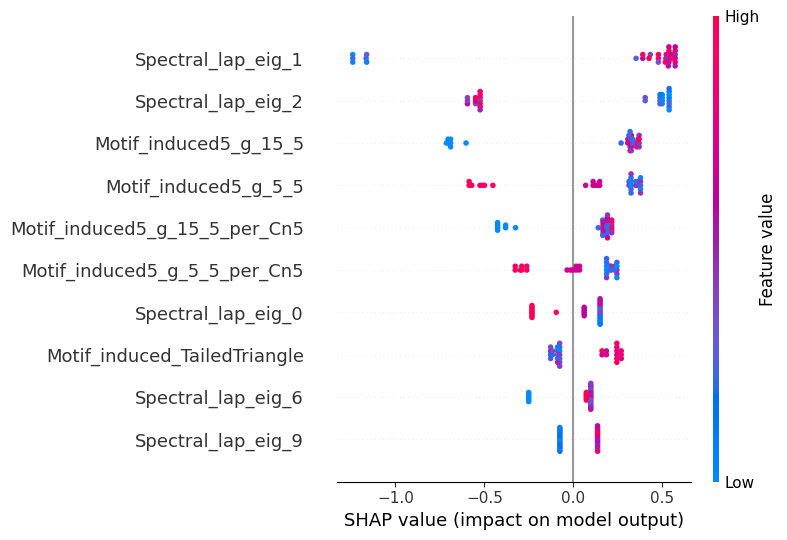

In [68]:
i = 6
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs[cols0 + ['loops','COEFFICIENTS']],
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

feature_columns = cols0
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=6)

# Compute all three perspectives together
importance_df = get_global_feature_importance(shap_values, feature_columns)
direction_df  = get_global_feature_direction(shap_values, feature_columns)

# Merge for a full picture
summary_df = importance_df.merge(direction_df, on='feature')

# Rank by signed mean SHAP (directional effect)
most_positive = summary_df.sort_values('mean_signed_shap', ascending=False).head(10)
most_negative = summary_df.sort_values('mean_signed_shap', ascending=True).head(10)

# Rank by absolute importance
most_important = summary_df.sort_values('importance', ascending=False).head(10)

#print("🔺 Most positive (increase prediction):")
#print(most_positive[['feature', 'mean_signed_shap', 'importance']])

#print("\n🔻 Most negative (decrease prediction):")
#print(most_negative[['feature', 'mean_signed_shap', 'importance']])

print("\n⭐ Most important overall (by |SHAP|):")
print(most_important[['feature', 'mean_signed_shap', 'importance']])
shap.summary_plot(shap_values, X_scaled, feature_names=feature_columns, max_display = 10)


Data shape: (31, 88)
Features: 86
Target distribution: {np.int64(0): np.int64(7), np.int64(1): np.int64(24)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.760 ± 0.185 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.500 ± 0.000 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.600 ± 0.126 | Params: {'n

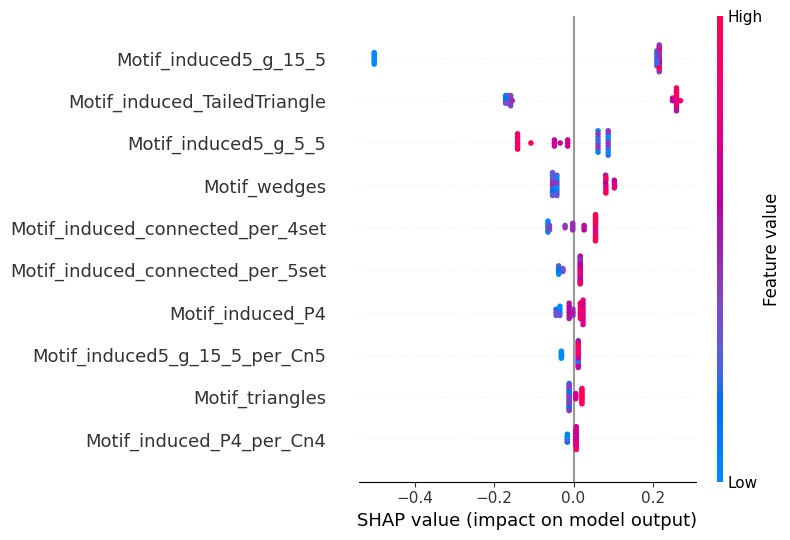

In [69]:
i = 6
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs[cols1 + ['loops','COEFFICIENTS']],
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

feature_columns = cols1
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=6)

# Compute all three perspectives together
importance_df = get_global_feature_importance(shap_values, feature_columns)
direction_df  = get_global_feature_direction(shap_values, feature_columns)

# Merge for a full picture
summary_df = importance_df.merge(direction_df, on='feature')

# Rank by signed mean SHAP (directional effect)
most_positive = summary_df.sort_values('mean_signed_shap', ascending=False).head(10)
most_negative = summary_df.sort_values('mean_signed_shap', ascending=True).head(10)

# Rank by absolute importance
most_important = summary_df.sort_values('importance', ascending=False).head(10)

#print("🔺 Most positive (increase prediction):")
#print(most_positive[['feature', 'mean_signed_shap', 'importance']])

#print("\n🔻 Most negative (decrease prediction):")
#print(most_negative[['feature', 'mean_signed_shap', 'importance']])

print("\n⭐ Most important overall (by |SHAP|):")
print(most_important[['feature', 'mean_signed_shap', 'importance']])
shap.summary_plot(shap_values, X_scaled, feature_names=feature_columns, max_display = 10)


In [55]:
# seven loops

i = 7
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i

results = intra_bayesian_optimization(
        dfs,
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (164, 244)
Features: 242
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.844 ± 0.056 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.787 ± 0.061 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.846 ± 0.048 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.815 ± 0.054 | Params

In [56]:
i = 7
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs[cols + ['loops','COEFFICIENTS']],
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (164, 98)
Features: 96
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.760 ± 0.072 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.743 ± 0.070 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.778 ± 0.074 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.773 ± 0.080 | Params: 


⭐ Most important overall (by |SHAP|):
                             feature  mean_signed_shap  importance
0                 Spectral_lap_eig_1          0.080106    0.792684
1                 Spectral_lap_eig_2         -0.026479    0.493848
2                   Motif_induced_P4          0.071988    0.341773
3       Motif_induced_TailedTriangle          0.100983    0.328727
4                 Spectral_lap_eig_5          0.021416    0.286486
5  Motif_triangle_edge_incidence_std          0.022105    0.178995
6                 Spectral_lap_eig_8         -0.000035    0.138077
7               Motif_induced5_g_4_5          0.010930    0.118077
8                 Spectral_lap_eig_3         -0.010145    0.112951
9             Motif_4_cycles_per_Cn4          0.025518    0.110847


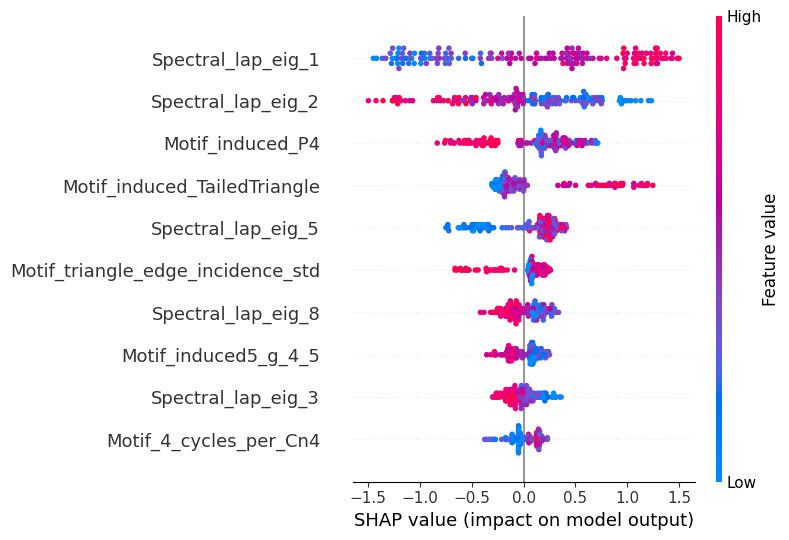

In [58]:
feature_columns = cols
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=i)

# Compute all three perspectives together
importance_df = get_global_feature_importance(shap_values, feature_columns)
direction_df  = get_global_feature_direction(shap_values, feature_columns)

# Merge for a full picture
summary_df = importance_df.merge(direction_df, on='feature')

# Rank by signed mean SHAP (directional effect)
most_positive = summary_df.sort_values('mean_signed_shap', ascending=False).head(10)
most_negative = summary_df.sort_values('mean_signed_shap', ascending=True).head(10)

# Rank by absolute importance
most_important = summary_df.sort_values('importance', ascending=False).head(10)

#print("🔺 Most positive (increase prediction):")
#print(most_positive[['feature', 'mean_signed_shap', 'importance']])

#print("\n🔻 Most negative (decrease prediction):")
#print(most_negative[['feature', 'mean_signed_shap', 'importance']])

print("\n⭐ Most important overall (by |SHAP|):")
print(most_important[['feature', 'mean_signed_shap', 'importance']])
shap.summary_plot(shap_values, X_scaled, feature_names=feature_columns, max_display = 10)


In [59]:
# seven loops

i = 8
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i

results = intra_bayesian_optimization(
        dfs,
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (1432, 242)
Features: 240
Target distribution: {np.int64(0): np.int64(703), np.int64(1): np.int64(729)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.900 ± 0.017 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.886 ± 0.015 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.890 ± 0.016 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.878 ± 0.015 | Para

In [60]:
i = 8
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs[cols + ['loops','COEFFICIENTS']],
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (1432, 98)
Features: 96
Target distribution: {np.int64(0): np.int64(703), np.int64(1): np.int64(729)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.845 ± 0.011 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.838 ± 0.014 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.838 ± 0.011 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.836 ± 0.014 | Params


⭐ Most important overall (by |SHAP|):
                             feature  mean_signed_shap  importance
0                 Spectral_lap_eig_1         -0.180238    1.337609
1                 Spectral_lap_eig_2         -0.125259    0.620158
2                 Spectral_lap_eig_6          0.047568    0.512099
3                 Spectral_lap_eig_3         -0.046599    0.365681
4                 Spectral_lap_eig_7          0.009497    0.362194
5       Motif_induced_TailedTriangle          0.068479    0.342492
6                 Spectral_lap_eig_5          0.004799    0.340020
7                 Spectral_lap_eig_8          0.062733    0.336335
8  Motif_triangle_edge_incidence_std          0.013842    0.333575
9                 Spectral_lap_eig_0          0.021923    0.321766


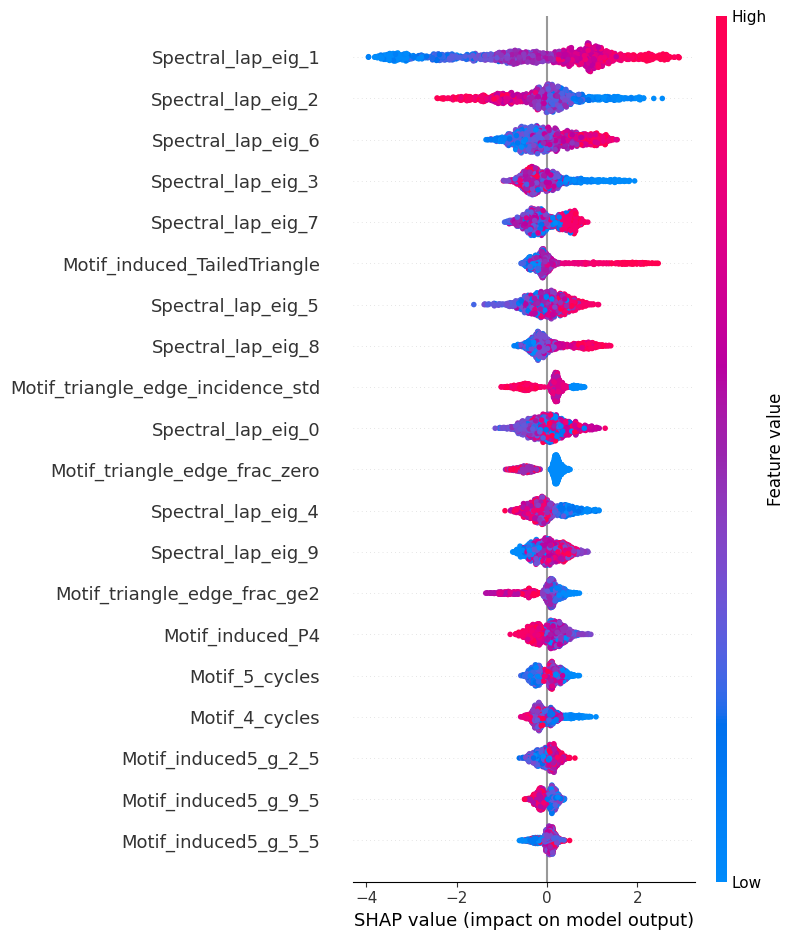

In [62]:
feature_columns = cols
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=i)

# Compute all three perspectives together
importance_df = get_global_feature_importance(shap_values, feature_columns)
direction_df  = get_global_feature_direction(shap_values, feature_columns)

# Merge for a full picture
summary_df = importance_df.merge(direction_df, on='feature')

# Rank by signed mean SHAP (directional effect)
most_positive = summary_df.sort_values('mean_signed_shap', ascending=False).head(10)
most_negative = summary_df.sort_values('mean_signed_shap', ascending=True).head(10)

# Rank by absolute importance
most_important = summary_df.sort_values('importance', ascending=False).head(10)

#print("🔺 Most positive (increase prediction):")
#print(most_positive[['feature', 'mean_signed_shap', 'importance']])

#print("\n🔻 Most negative (decrease prediction):")
#print(most_negative[['feature', 'mean_signed_shap', 'importance']])

print("\n⭐ Most important overall (by |SHAP|):")
print(most_important[['feature', 'mean_signed_shap', 'importance']])
shap.summary_plot(shap_values, X_scaled, feature_names=feature_columns, max_display = 20)


In [63]:
i = 9
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs,
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (13972, 243)
Features: 241
Target distribution: {np.int64(0): np.int64(8311), np.int64(1): np.int64(5661)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.940 ± 0.002 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.930 ± 0.002 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.931 ± 0.002 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.922 ± 0.002 | P

In [64]:
i = 9
dfs = pd.read_csv(f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/merged/new_merged/{i}loops_merged.csv")
dfs['loops'] = i


results = intra_bayesian_optimization(
        dfs[cols + ['loops','COEFFICIENTS']],
        i,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )

Data shape: (13972, 98)
Features: 96
Target distribution: {np.int64(0): np.int64(8311), np.int64(1): np.int64(5661)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.894 ± 0.003 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.889 ± 0.004 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.890 ± 0.002 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.890 ± 0.003 | Par


⭐ Most important overall (by |SHAP|):
                             feature  mean_signed_shap  importance
0                 Spectral_lap_eig_1         -0.551173    1.648193
1                 Spectral_lap_eig_6         -0.018383    0.393431
2                 Spectral_lap_eig_2         -0.085447    0.389510
3                 Spectral_lap_eig_9         -0.017293    0.304843
4       Motif_triangle_edge_frac_ge2         -0.121378    0.296331
5                 Spectral_lap_eig_7         -0.006294    0.294000
6                 Spectral_lap_eig_8         -0.012499    0.287848
7  Motif_triangle_edge_incidence_std         -0.000997    0.262632
8      Motif_triangle_edge_frac_zero         -0.015670    0.257505
9                 Spectral_lap_eig_4         -0.044592    0.214566


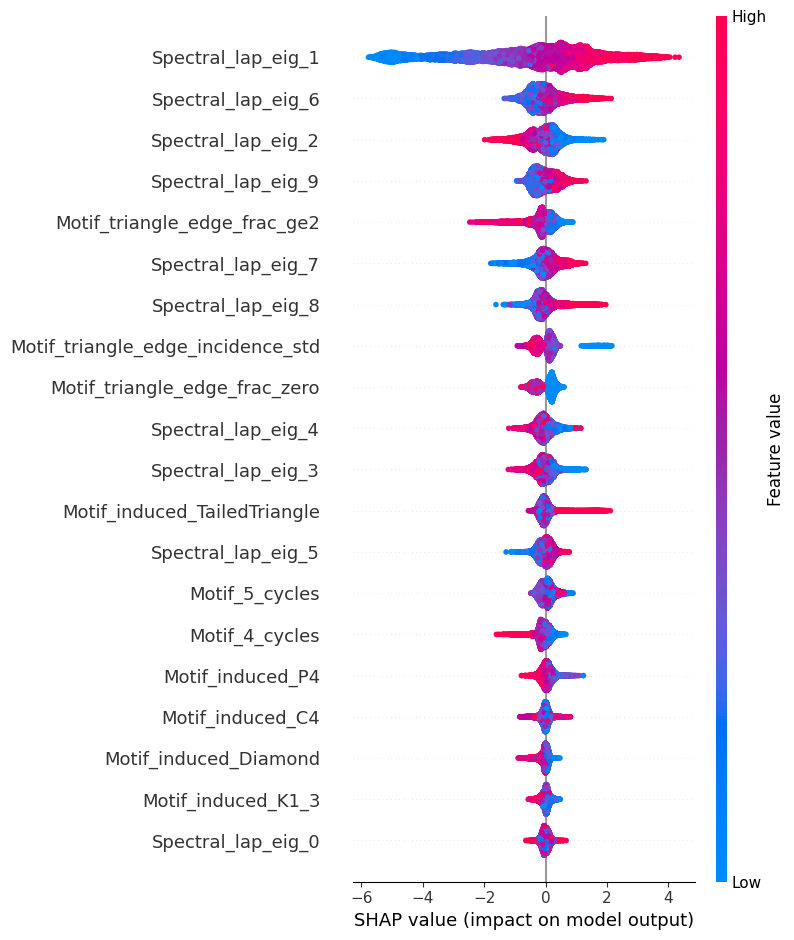

In [65]:
feature_columns = cols
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=i)

# Compute all three perspectives together
importance_df = get_global_feature_importance(shap_values, feature_columns)
direction_df  = get_global_feature_direction(shap_values, feature_columns)

# Merge for a full picture
summary_df = importance_df.merge(direction_df, on='feature')

# Rank by signed mean SHAP (directional effect)
most_positive = summary_df.sort_values('mean_signed_shap', ascending=False).head(10)
most_negative = summary_df.sort_values('mean_signed_shap', ascending=True).head(10)

# Rank by absolute importance
most_important = summary_df.sort_values('importance', ascending=False).head(10)

#print("🔺 Most positive (increase prediction):")
#print(most_positive[['feature', 'mean_signed_shap', 'importance']])

#print("\n🔻 Most negative (decrease prediction):")
#print(most_negative[['feature', 'mean_signed_shap', 'importance']])

print("\n⭐ Most important overall (by |SHAP|):")
print(most_important[['feature', 'mean_signed_shap', 'importance']])
shap.summary_plot(shap_values, X_scaled, feature_names=feature_columns, max_display = 20)


In [ ]:
##### STUDY DONE FOR MOMENT 

In [184]:
feature_columns = cols 
shap_values, explainer, model, X_scaled = calculate_global_shap_values(dfs, feature_columns, results['best_params'], target_loop=i)
get_global_feature_importance(shap_values, feature_columns)[:10]

,feature,importance
23,Spectral_laplacian_heat_trace_t5.0,0.934753
96,Spectral_laplacian_heat_trace_t2.0,0.827919
15,Motif_induced_P4,0.701537
47,Motif_induced5_g_2_5,0.230123
2,Spectral_laplacian_skew,0.203571
8,Motif_triangle_edge_incidence_std,0.190070
46,Motif_induced5_g_1_5,0.173462
50,Motif_induced5_g_5_5,0.149355
60,Motif_induced5_g_15_5,0.145102
53,Motif_induced5_g_8_5,0.130357


In [175]:
shap_values.shape

(31, 97)

In [177]:
len(cols)

97

In [103]:
all_results = []
for i in tqdm(range(1,len(subsets))):
    columns = flatten_list_comprehension([mapping[x] for x in subsets[i]])
    result = intra_bayesian_optimization(
        dfs[columns + ['loops','COEFFICIENTS']],
        7,
        n_calls=20,
        n_splits=5,
        n_workers=8,                 
        results_dir="bayes_results", 
        save_plot=False,
        random_state=42
    )
    all_results.append(result)

  0%|          | 0/7 [00:00<?, ?it/s]

Data shape: (164, 88)
Features: 86
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.704 ± 0.082 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.694 ± 0.088 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.733 ± 0.061 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.721 ± 0.065 | Params: 

 14%|█▍        | 1/7 [00:18<01:49, 18.33s/it]

Fold 5 ROC AUC: 0.680

Average ROC AUC: 0.761 ± 0.052

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.7611
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211635
Data shape: (164, 110)
Features: 87
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.706 ± 0.085 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.671 ± 0.101 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.

 29%|██▊       | 2/7 [00:34<01:26, 17.26s/it]

Fold 5 ROC AUC: 0.645

Average ROC AUC: 0.765 ± 0.077

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.7647
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211653
Data shape: (164, 120)
Features: 92
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.737 ± 0.090 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.704 ± 0.066 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.

 43%|████▎     | 3/7 [00:54<01:13, 18.41s/it]

Fold 5 ROC AUC: 0.649

Average ROC AUC: 0.782 ± 0.089

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.7818
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211710
Data shape: (164, 132)
Features: 99
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.732 ± 0.091 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.699 ± 0.092 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.

 57%|█████▋    | 4/7 [01:15<00:58, 19.42s/it]

Fold 5 ROC AUC: 0.684

Average ROC AUC: 0.771 ± 0.081

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.7707
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211730
Data shape: (164, 150)
Features: 117
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.741 ± 0.089 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.713 ± 0.045 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0

 71%|███████▏  | 5/7 [01:36<00:39, 19.97s/it]

Fold 5 ROC AUC: 0.684

Average ROC AUC: 0.767 ± 0.074

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.7667
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211751
Data shape: (164, 183)
Features: 150
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.816 ± 0.040 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.799 ± 0.039 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0

 86%|████████▌ | 6/7 [01:55<00:19, 19.74s/it]

Fold 5 ROC AUC: 0.853

Average ROC AUC: 0.851 ± 0.051

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.8507
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211812
Data shape: (164, 240)
Features: 207
Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(107)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.836 ± 0.052 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.823 ± 0.050 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0

100%|██████████| 7/7 [02:16<00:00, 19.44s/it]

Fold 5 ROC AUC: 0.857

Average ROC AUC: 0.846 ± 0.021

SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.8462
Artifacts saved to: /Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/bayes_results/loop7_20251025-211831


In [104]:
row = []
for i in range(len(all_results)):
    row.append([subsets[i] ,all_results[i]['best_cv_score'],all_results[i]['cv_auc_std']])
pd.DataFrame(row,columns=['subset','best_cv_score','cv_auc_std'])


,subset,best_cv_score,cv_auc_std
0,"[Motifs_3_4, Motifs_4, Motifs_5]",0.761124,0.052415
1,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.764712,0.076748
2,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.781812,0.088931
3,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.770655,0.080581
4,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.766686,0.074307
5,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.850735,0.051040
6,"[Motifs_3_4, Motifs_4, Motifs_5, Motifs_3_4_No...",0.846248,0.020911


In [ ]:
result['best_cv_score'], raesult['cv_auc_std']

(0.8699999999999999, 0.19390719429665315)

In [ ]:
simple_mapping['Motifs_3_4_Normalized'], 'Motifs_4', 'Motifs_4_Normalized', 'Motifs_5', 'Motifs_5_Normalized']]

dict_keys(['Basic', 'Basic_Normalized', 'Centrality', 'Centrality_Normalized', 'Community', 'Connectivity', 'Connectivity_Normalized', 'Core', 'Cycles', 'Motifs_3_4', 'Motifs_3_4_Normalized', 'Motifs_4', 'Motifs_4_Normalized', 'Motifs_5', 'Motifs_5_Normalized', 'NetLSD', 'Planarity', 'Planarity_Normalized', 'Robustness', 'Robustness_Normalized', 'Spectral_Adjacency', 'Spectral_Laplacian', 'Spectral_Normalized', 'Symmetry', 'Symmetry_Normalized', 'TDA', 'TDA_Normalized'])

In [12]:
intra_bayesian_optimization(
    dfs,
    7,
    n_calls=20,
    n_splits=5,
    n_workers=8,                 
    results_dir="bayes_results", 
    save_plot=False,
    random_state=42
)

Data shape: (0, 240)
Features: 207
Target distribution: {}

Starting Bayesian Hyperparameter Optimization
Error with params {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error with params {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error with params {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [33]:
intra_bayesian_optimization(
    dfs,
    8,
    n_calls=20,
    n_splits=5,
    n_workers=8,                 
    results_dir="bayes_results", 
    save_plot=False,
    random_state=42
)

Data shape: (1432, 102)
Features: 74
Target distribution: {np.int64(0): np.int64(703), np.int64(1): np.int64(729)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.801 ± 0.029 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.797 ± 0.032 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.796 ± 0.034 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.795 ± 0.029 | Param

{'best_params': {'n_estimators': np.int64(215),
  'max_depth': np.int64(10),
  'learning_rate': 0.06284846545853807,
  'subsample': 0.9021445641270611,
  'colsample_bytree': 0.7700623497964979,
  'reg_alpha': 2.079416628681889,
  'reg_lambda': 5.677003278199916},
 'best_cv_score': 0.8087760202423666,
 'cv_auc': 0.8087760202423666,
 'cv_auc_std': 0.03451587270665487,
 'optimization_history_df':     n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
 0            807          6       0.236110   0.838740          0.778333   
 1            367          5       0.198758   0.622565          0.888800   
 2            993         13       0.187379   0.602827          0.609225   
 3             94         20       0.077504   0.636243          0.847354   
 4            493         18       0.207289   0.780200          0.605306   
 5            416          3       0.076959   0.696410          0.873305   
 6            215         10       0.062848   0.902145          0.770062

In [34]:
intra_bayesian_optimization(
    dfs,
    9,
    n_calls=20,
    n_splits=5,
    n_workers=8,                 
    results_dir="bayes_results", 
    save_plot=False,
    random_state=42
)

Data shape: (13972, 102)
Features: 74
Target distribution: {np.int64(0): np.int64(8311), np.int64(1): np.int64(5661)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.843 ± 0.003 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.850 ± 0.003 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.843 ± 0.004 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.853 ± 0.004 | Pa

{'best_params': {'n_estimators': np.int64(98),
  'max_depth': np.int64(9),
  'learning_rate': 0.0896940755775334,
  'subsample': 0.9967432400492232,
  'colsample_bytree': 0.8014777223635612,
  'reg_alpha': 4.63099109935445,
  'reg_lambda': 0.2194542790239529},
 'best_cv_score': 0.8619078715110596,
 'cv_auc': 0.8619078715110596,
 'cv_auc_std': 0.00394596885964052,
 'optimization_history_df':     n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
 0            807          6       0.236110   0.838740          0.778333   
 1            367          5       0.198758   0.622565          0.888800   
 2            993         13       0.187379   0.602827          0.609225   
 3             94         20       0.077504   0.636243          0.847354   
 4            493         18       0.207289   0.780200          0.605306   
 5            416          3       0.076959   0.696410          0.873305   
 6            215         10       0.062848   0.902145          0.770062   

In [35]:
intra_bayesian_optimization(
    dfs,
    10,
    n_calls=20,
    n_splits=5,
    n_workers=8,                 
    results_dir="bayes_results", 
    save_plot=False,
    random_state=42
)

Data shape: (153252, 102)
Features: 74
Target distribution: {np.int64(0): np.int64(101989), np.int64(1): np.int64(51263)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.878 ± 0.003 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.879 ± 0.003 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.871 ± 0.002 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.882 ± 0.002 

{'best_params': {'n_estimators': np.int64(783),
  'max_depth': np.int64(18),
  'learning_rate': 0.01,
  'subsample': 0.6961746330415858,
  'colsample_bytree': 0.9051872552959941,
  'reg_alpha': 4.1996540960176825,
  'reg_lambda': 4.3643040857948545},
 'best_cv_score': 0.8847634059809348,
 'cv_auc': 0.8847634059809348,
 'cv_auc_std': 0.002509671949479659,
 'optimization_history_df':     n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
 0            807          6       0.236110   0.838740          0.778333   
 1            367          5       0.198758   0.622565          0.888800   
 2            993         13       0.187379   0.602827          0.609225   
 3             94         20       0.077504   0.636243          0.847354   
 4            493         18       0.207289   0.780200          0.605306   
 5            416          3       0.076959   0.696410          0.873305   
 6            215         10       0.062848   0.902145          0.770062   
 7      

In [37]:
intra_bayesian_optimization(
    dfs,
    11,
    n_calls=10,
    n_splits=5,
    n_workers=8,                 
    results_dir="bayes_results", 
    save_plot=False,
    random_state=42
)

Data shape: (1697302, 102)
Features: 74
Target distribution: {np.int64(0): np.int64(1207883), np.int64(1): np.int64(489419)}

Starting Bayesian Hyperparameter Optimization


KeyboardInterrupt: 

Data shape: (13972, 102)
Features: 74
Target distribution: {np.int64(0): np.int64(8311), np.int64(1): np.int64(5661)}

Starting Bayesian Hyperparameter Optimization
CV Score: 0.843 ± 0.003 | Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
CV Score: 0.850 ± 0.003 | Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
CV Score: 0.843 ± 0.004 | Params: {'n_estimators': np.int64(993), 'max_depth': np.int64(13), 'learning_rate': 0.18737941654160148, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'reg_alpha': 5.247746602583892, 'reg_lambda': 3.998609717152556}
CV Score: 0.853 ± 0.004 | Pa

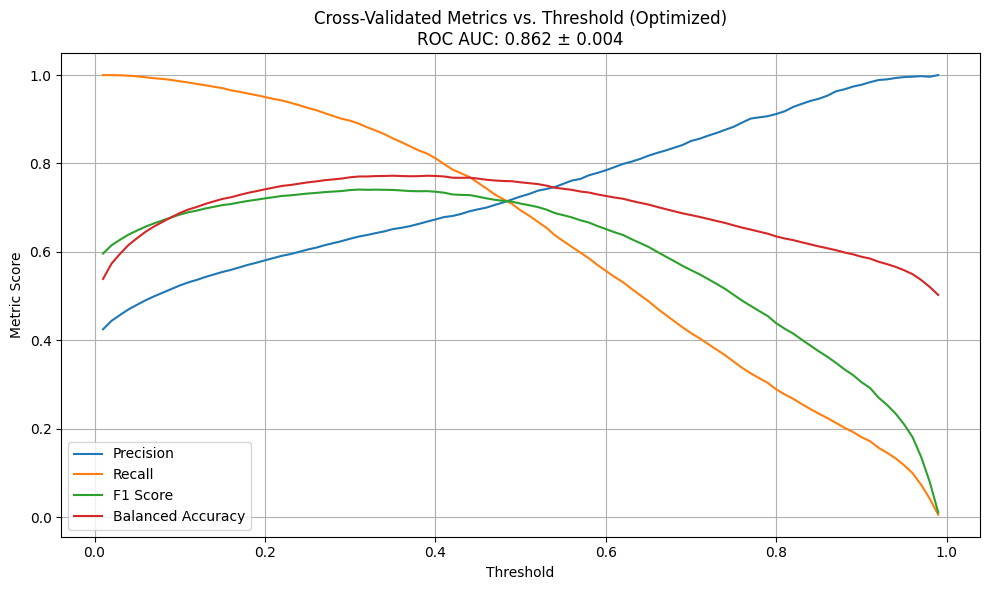


SUMMARY
✓ Bayesian optimization completed with 20 iterations
✓ Best CV score: 0.8619


In [26]:
intra_bayesian_optimization(dfs, 9)

In [44]:
# =============================================================================
# Expanding-window Bayesian Optimization by loop (with per-loop val metrics)
# =============================================================================

import json, time
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)
from xgboost import XGBClassifier
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args


# Small JSON helper (matches your intra-loop version)
def _json_safe(o):
    import numpy as _np
    if isinstance(o, (_np.int32, _np.int64, int)):
        return int(o)
    elif isinstance(o, (_np.float32, _np.float64, float)):
        return float(o)
    elif isinstance(o, (_np.ndarray,)):
        return o.tolist()
    else:
        raise TypeError(f"Object of type {type(o).__name__} is not JSON serializable")


def interloop_bayesian_optimization(
    dfs,
    *,
    start_loop=5,          # first loop to include in training
    upper_bound=9,         # last loop used as validation in expanding scheme
    final_test_loop=10,    # held-out "future" loop for final evaluation
    n_calls=20,
    n_workers=1,           # parallel workers (per val-split & XGB n_jobs)
    results_dir="bayes_results_inter",
    save_plot=True,
    random_state=42,
    loop_col="loops",
    target_col="COEFFICIENTS"
):
    """
    Expanding-window, time-series by-loop Bayesian optimization.

    Validation splits:
      Train: [start_loop .. v-1], Validate on: v   for each v in [start_loop+2 .. upper_bound]
    Example with start_loop=5, upper_bound=9:
      - Train 5,6  -> Val 7
      - Train 5-7  -> Val 8
      - Train 5-8  -> Val 9

    After BO:
      - Fit on [start_loop .. upper_bound] and test on final_test_loop.

    Artifacts (under {results_dir}/{timestamp}/):
      - summary.json
      - history.csv           (includes per-loop AUC columns: auc_val_7, auc_val_8, ...)
      - thresholds.csv        (final_test_loop sweep)
      - metrics.png           (final_test_loop sweep)
    """
    # -----------------------------
    # Validate inputs & build features
    # -----------------------------
    if loop_col not in dfs.columns:
        raise ValueError(f"'{loop_col}' column not found.")
    if target_col not in dfs.columns:
        raise ValueError(f"'{target_col}' column not found.")

    # Match your original feature filtering logic
    data_cols = [
        c for c in dfs.columns
        if 'COEFFICIENTS' not in c and 'loop' not in c and 'Spectral' not in c and c != loop_col
    ]
    X_all = dfs[data_cols].values
    y_all = dfs[target_col].values.ravel()
    loops_all = dfs[loop_col].values

    # Ensure required loops exist
    uniq_loops = sorted(pd.unique(loops_all))
    needed = list(range(start_loop, upper_bound + 1)) + [final_test_loop]
    missing = [l for l in needed if l not in uniq_loops]
    if missing:
        raise ValueError(f"Missing required loops in data: {missing}")

    # Build expanding validation splits (train up to v-1, validate on v)
    val_loops = list(range(start_loop + 2, upper_bound + 1))  # e.g., 7..9 for start=5,upper=9
    splits = []
    for v in val_loops:
        train_mask = (loops_all >= start_loop) & (loops_all <= (v - 1))
        val_mask   = (loops_all == v)
        train_idx = np.where(train_mask)[0]
        val_idx   = np.where(val_mask)[0]
        if len(train_idx) == 0 or len(val_idx) == 0:
            raise ValueError(f"No samples for train up to {v-1} or val {v}.")
        splits.append((train_idx, val_idx, v))

    print("="*60)
    print("Expanding-Window Bayesian Optimization (by loop)")
    print("="*60)
    print(f"Features: {len(data_cols)} | Samples: {len(dfs)}")
    print(f"Train start loop: {start_loop}")
    print(f"Validation loops: {val_loops}")
    print(f"Final test loop:  {final_test_loop}")

    # Results directory
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = Path(results_dir) / f"loops{start_loop}-{upper_bound}_final{final_test_loop}_{ts}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # -----------------------------
    # Search space (same flavor as your intra-loop)
    # -----------------------------
    dimensions = [
        Integer(50, 1000, name='n_estimators'),
        Integer(3, 20, name='max_depth'),
        Real(0.01, 0.3, name='learning_rate'),
        Real(0.6, 1.0, name='subsample'),
        Real(0.6, 1.0, name='colsample_bytree'),
        Real(0.0, 10.0, name='reg_alpha'),
        Real(0.0, 10.0, name='reg_lambda'),
    ]

    # Helper: single split fit/eval
    def _fit_eval_split(train_idx, val_idx, params):
        X_tr, X_va = X_all[train_idx], X_all[val_idx]
        y_tr, y_va = y_all[train_idx], y_all[val_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        model = XGBClassifier(
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=n_workers,
            **params
        )
        model.fit(X_tr, y_tr)
        y_scores = model.predict_proba(X_va)[:, 1]
        return roc_auc_score(y_va, y_scores)

    history_rows = []

    # -----------------------------
    # Objective with per-loop validation metrics (printed + saved)
    # -----------------------------
    @use_named_args(dimensions=dimensions)
    def objective(**params):
        try:
            # Evaluate each validation loop separately (so we can record their AUCs)
            results = Parallel(n_jobs=n_workers, prefer="threads")(
                delayed(_fit_eval_split)(train_idx, val_idx, params)
                for (train_idx, val_idx, v_loop) in splits
            )

            aucs_by_loop = {f"auc_val_{v_loop}": float(a) for (_, _, v_loop), a in zip(splits, results)}
            mean_auc = float(np.mean(list(aucs_by_loop.values())))
            std_auc  = float(np.std(list(aucs_by_loop.values())))

            # Pretty print per-loop metrics
            print("\n----------------------------------------")
            print(f"Params: {params}")
            for v_key in sorted(aucs_by_loop.keys(), key=lambda k: int(k.split('_')[-1])):
                print(f"  {v_key}: {aucs_by_loop[v_key]:.3f}")
            print(f"→ Mean AUC: {mean_auc:.3f} ± {std_auc:.3f}")
            print("----------------------------------------")

            # Persist to history (wide format with per-loop columns)
            row = {**params, **aucs_by_loop,
                   "mean_auc": mean_auc,
                   "std_auc": std_auc,
                   "timestamp": time.time()}
            history_rows.append(row)

            return -mean_auc  # minimize

        except Exception as e:
            print(f"Error with params {params}: {e}")
            history_rows.append({**params, "mean_auc": np.nan, "std_auc": np.nan,
                                 "error": str(e), "timestamp": time.time()})
            return 1.0

    # -----------------------------
    # Run BO
    # -----------------------------
    print("\nStarting Bayesian search ...")
    result = gp_minimize(
        func=objective,
        dimensions=dimensions,
        n_calls=n_calls,
        random_state=random_state,
        acq_func='EI'
    )

    # Save optimization history CSV (includes per-loop AUC columns)
    hist_df = pd.DataFrame(history_rows)
    hist_path = run_dir / "history.csv"
    hist_df.to_csv(hist_path, index=False)

    # Best params
    best_params = dict(zip([d.name for d in dimensions], result.x))
    best_score = float(-result.fun)

    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Best expanding-val AUC: {best_score:.4f}")
    print("Best Parameters:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    # -----------------------------
    # Final Train (start..upper_bound) → Test (final_test_loop)
    # -----------------------------
    print("\n" + "="*60)
    print(f"FINAL EVALUATION on loop {final_test_loop}")
    print("="*60)

    train_mask_final = (loops_all >= start_loop) & (loops_all <= upper_bound)
    test_mask_final  = (loops_all == final_test_loop)
    tr_idx_final = np.where(train_mask_final)[0]
    te_idx_final = np.where(test_mask_final)[0]
    if len(tr_idx_final) == 0 or len(te_idx_final) == 0:
        raise ValueError("No samples for final train or test.")

    X_tr, X_te = X_all[tr_idx_final], X_all[te_idx_final]
    y_tr, y_te = y_all[tr_idx_final], y_all[te_idx_final]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    final_model = XGBClassifier(
        eval_metric='logloss',
        random_state=random_state,
        n_jobs=n_workers,
        **best_params
    )
    final_model.fit(X_tr, y_tr)
    y_scores = final_model.predict_proba(X_te)[:, 1]
    final_auc = float(roc_auc_score(y_te, y_scores))
    print(f"Final hold-out AUC (loop {final_test_loop}): {final_auc:.4f}")

    # Threshold sweep on the held-out test loop
    thresholds = np.linspace(0.01, 0.99, 99)
    precisions = []
    recalls = []
    f1s = []
    balanced_accuracies = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        precisions.append(precision_score(y_te, y_pred, zero_division=0))
        recalls.append(recall_score(y_te, y_pred))
        f1s.append(f1_score(y_te, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_te, y_pred))

    thr_df = pd.DataFrame({
        "threshold": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": balanced_accuracies
    })
    thr_path = run_dir / "thresholds.csv"
    thr_df.to_csv(thr_path, index=False)

    plot_path = None
    if save_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, precisions, label="Precision")
        plt.plot(thresholds, recalls, label="Recall")
        plt.plot(thresholds, f1s, label="F1 Score")
        plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
        plt.xlabel("Threshold")
        plt.ylabel("Metric Score")
        plt.title(
            f"Metrics vs. Threshold on Loop {final_test_loop}\n"
            f"Final AUC: {final_auc:.3f} | Train Loops: {start_loop}-{upper_bound}"
        )
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plot_path = run_dir / "metrics.png"
        plt.savefig(plot_path, dpi=160)
        plt.close()

    # -----------------------------
    # Persist summary
    # -----------------------------
    summary = {
        "loops": {
            "start_loop": int(start_loop),
            "upper_bound": int(upper_bound),
            "final_test_loop": int(final_test_loop),
            "validation_loops": val_loops
        },
        "timestamp": ts,
        "n_calls": int(n_calls),
        "n_workers": int(n_workers),
        "random_state": int(random_state),
        "feature_count": int(len(data_cols)),
        "best_params": best_params,
        "best_expanding_val_auc": best_score,
        "final_test_auc": final_auc,
        "paths": {
            "run_dir": str(run_dir.resolve()),
            "history_csv": str(hist_path.resolve()),
            "thresholds_csv": str(thr_path.resolve()),
            "plot_png": str(plot_path.resolve()) if plot_path else None
        }
    }
    with open(run_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2, default=_json_safe)

    # Return programmatic result
    return {
        "best_params": best_params,
        "best_expanding_val_auc": best_score,
        "final_test_auc": final_auc,
        "optimization_history_df": hist_df,  # convenient for inspection
        "thresholds_df": thr_df,
        "artifacts_dir": str(run_dir.resolve())
    }


In [47]:
interloop_bayesian_optimization(
    dfs,
    start_loop=5,          # first loop to include in training
    upper_bound=10,         # last loop used as validation in expanding scheme
    final_test_loop=11,    # held-out "future" loop for final evaluation
    n_calls=20,
    n_workers=8,           # parallel workers (per val-split & XGB n_jobs)
    results_dir="bayes_results_inter",
    save_plot=False,
    random_state=42,
    loop_col="loops",
    target_col="COEFFICIENTS"
)

Expanding-Window Bayesian Optimization (by loop)
Features: 74 | Samples: 1866160
Train start loop: 5
Validation loops: [7, 8, 9, 10]
Final test loop:  11

Starting Bayesian search ...

----------------------------------------
Params: {'n_estimators': np.int64(807), 'max_depth': np.int64(6), 'learning_rate': 0.23611039007910314, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'reg_alpha': 0.9997491581800291, 'reg_lambda': 4.592488919658672}
  auc_val_7: 0.575
  auc_val_8: 0.708
  auc_val_9: 0.724
  auc_val_10: 0.760
→ Mean AUC: 0.692 ± 0.070
----------------------------------------

----------------------------------------
Params: {'n_estimators': np.int64(367), 'max_depth': np.int64(5), 'learning_rate': 0.19875765715516736, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'reg_alpha': 9.385527090157504, 'reg_lambda': 0.007787658410143285}
  auc_val_7: 0.500
  auc_val_8: 0.725
  auc_val_9: 0.760
  auc_val_10: 0.771
→ Mean AUC: 0.689 ± 0.110

{'best_params': {'n_estimators': np.int64(374),
  'max_depth': np.int64(8),
  'learning_rate': 0.01,
  'subsample': 0.7972459493836414,
  'colsample_bytree': 0.6,
  'reg_alpha': 3.7989082412307553,
  'reg_lambda': 10.0},
 'best_expanding_val_auc': 0.7430356119807198,
 'final_test_auc': 0.8131365745096941,
 'optimization_history_df':     n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
 0            807          6       0.236110   0.838740          0.778333   
 1            367          5       0.198758   0.622565          0.888800   
 2            993         13       0.187379   0.602827          0.609225   
 3             94         20       0.077504   0.636243          0.847354   
 4            493         18       0.207289   0.780200          0.605306   
 5            416          3       0.076959   0.696410          0.873305   
 6            215         10       0.062848   0.902145          0.770062   
 7             80         17       0.140429   0.758060    

(164, 102)
Fold 1 ROC AUC: 0.843
Fold 2 ROC AUC: 0.793
Fold 3 ROC AUC: 0.798
Fold 4 ROC AUC: 0.901
Fold 5 ROC AUC: 0.654

Average ROC AUC: 0.798 ± 0.082


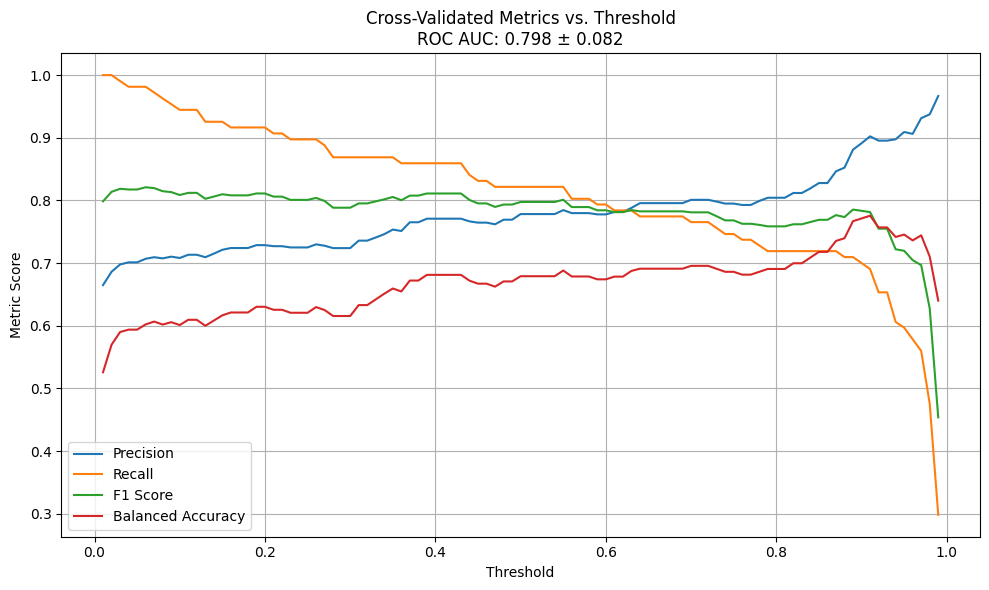

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 7]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(1432, 102)
Fold 1 ROC AUC: 0.871
Fold 2 ROC AUC: 0.856
Fold 3 ROC AUC: 0.858
Fold 4 ROC AUC: 0.870
Fold 5 ROC AUC: 0.834

Average ROC AUC: 0.858 ± 0.013


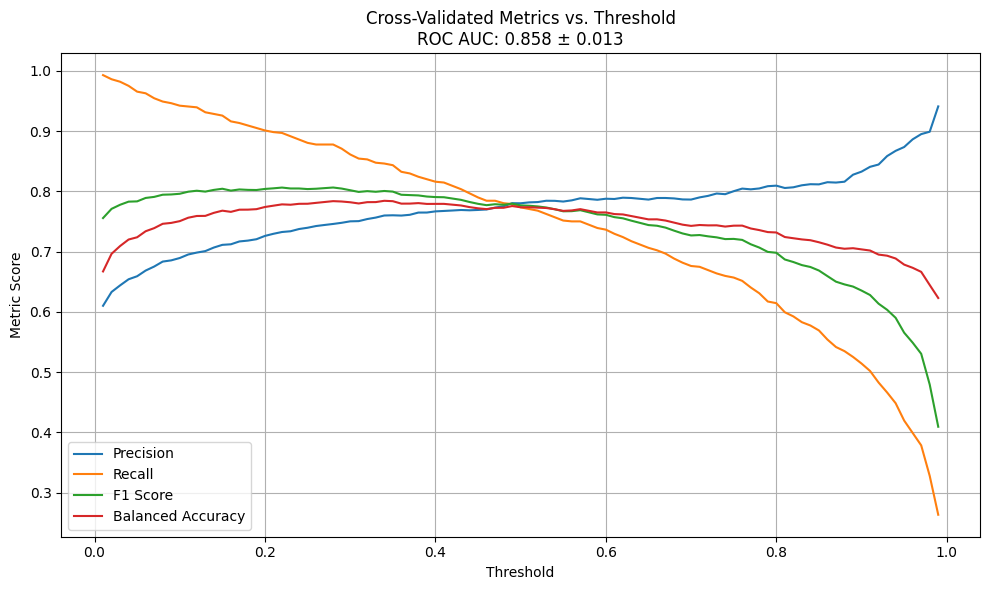

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 8]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(13972, 102)
Fold 1 ROC AUC: 0.895
Fold 2 ROC AUC: 0.898
Fold 3 ROC AUC: 0.889
Fold 4 ROC AUC: 0.896
Fold 5 ROC AUC: 0.895

Average ROC AUC: 0.895 ± 0.003


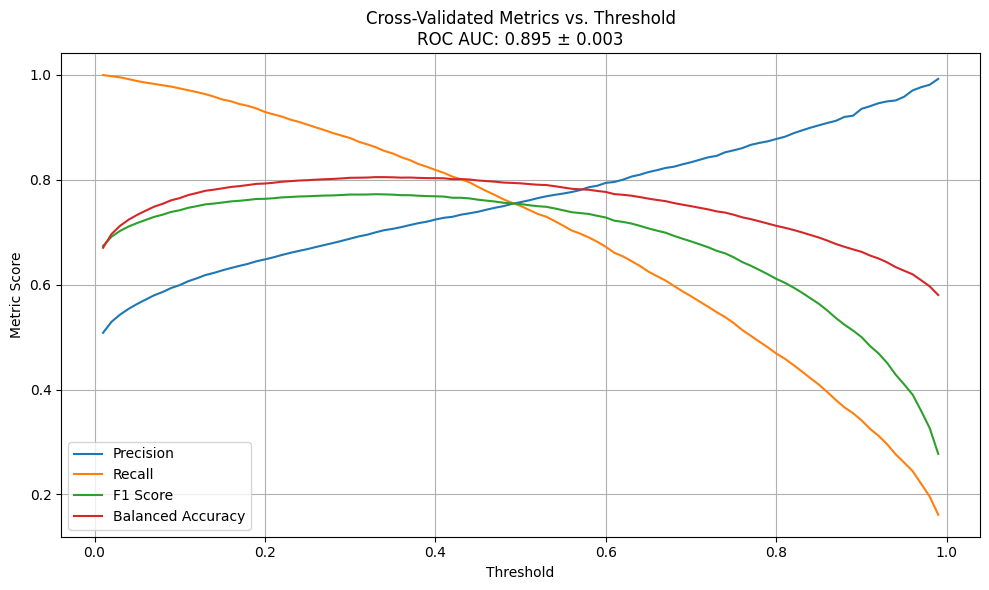

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 9]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 11]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(1697302, 102)


KeyboardInterrupt: 

In [14]:
from __future__ import annotations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any

def run_cv_threshold_curves(
    df: pd.DataFrame,
    target_col: str = "COEFFICIENTS",
    loop_col: str = "loops",
    loops_to_use: Sequence[int] = (6, 7),           # <- put any loop values here
    n_splits: int = 5,
    thresholds: np.ndarray | None = None,
    model_kwargs: Dict[str, Any] | None = None,
    scale: bool = False,                            # simple toggle; you can wire in StandardScaler if needed
    random_state: int = 42,
):
    """
    Cross-validated evaluation with per-loop ROC AUCs and threshold curves,
    for any set of loop values.

    Assumes binary classification (target in {0,1}).
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    if model_kwargs is None:
        model_kwargs = {}

    # --- filter to requested loops ---
    data = df[df[loop_col].isin(loops_to_use)].copy()
    if data.empty:
        raise ValueError("No rows match the requested loops_to_use.")

    # --- features/target ---
    feature_cols = [c for c in data.columns if c != target_col]
    X = data[feature_cols].to_numpy()
    y = data[target_col].to_numpy().ravel().astype(int)
    loops = data[loop_col].to_numpy()

    # --- stratify by (y, loop) to keep both label and loop balanced across folds ---
    stratify_labels = data[target_col].astype(str) + "_" + data[loop_col].astype(str)

    # --- accumulators for threshold curves (averaged across folds) ---
    thresholds = np.asarray(thresholds, dtype=float)
    precisions = np.zeros_like(thresholds, dtype=float)
    recalls = np.zeros_like(thresholds, dtype=float)
    f1s = np.zeros_like(thresholds, dtype=float)
    balanced_accuracies = np.zeros_like(thresholds, dtype=float)

    # --- per-loop AUCs store ---
    per_loop_aucs: Dict[int, list] = {lv: [] for lv in loops_to_use}

    # --- CV splitter ---
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        loops_test = loops[test_idx]

        # (Optional) scaling hook
        if scale:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # --- model ---
        model = XGBClassifier(eval_metric="logloss", random_state=random_state, **model_kwargs)
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]

        # --- per-loop AUCs ---
        for lv in loops_to_use:
            mask = (loops_test == lv)
            if mask.any():
                try:
                    auc = roc_auc_score(y_test[mask], y_scores[mask])
                except ValueError:
                    # happens if y has only one class in this subset
                    auc = np.nan
                per_loop_aucs[lv].append(auc)
                print(f"Fold {fold} ROC AUC (loop {lv}): {auc:.3f}" if auc == auc else
                      f"Fold {fold} ROC AUC (loop {lv}): NaN (single-class subset)")
            else:
                print(f"Fold {fold} has no samples for loop {lv}")

        # --- threshold-dependent metrics ---
        for i, t in enumerate(thresholds):
            y_pred = (y_scores >= t).astype(int)
            precisions[i] += precision_score(y_test, y_pred, zero_division=0)
            recalls[i] += recall_score(y_test, y_pred, zero_division=0)
            f1s[i] += f1_score(y_test, y_pred, zero_division=0)
            balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

    # --- average across folds ---
    precisions /= n_splits
    recalls /= n_splits
    f1s /= n_splits
    balanced_accuracies /= n_splits

    # --- print summary AUCs ---
    print("\nAverage ROC AUC by loop:")
    for lv in loops_to_use:
        vals = np.array(per_loop_aucs[lv], dtype=float)
        mean = np.nanmean(vals) if vals.size else np.nan
        std = np.nanstd(vals) if vals.size else np.nan
        print(f"  loop {lv}: {mean:.3f} ± {std:.3f}")

    # --- plot ---
    title_loops = ", ".join(map(str, loops_to_use))
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title(f"Cross-Validated Metrics vs. Threshold (Loops: {title_loops})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "thresholds": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": balanced_accuracies,
        "per_loop_aucs": per_loop_aucs,
    }

# ---------------- Example usage ----------------
# results = run_cv_threshold_curves(
#     df=dfs,
#     target_col="COEFFICIENTS",
#     loop_col="loops",
#     loops_to_use=[6, 7],          # put any values here, e.g. [10, 11] or [2, 4, 6]
#     n_splits=5,
#     model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
#     scale=False,
# )


Fold 1 ROC AUC (loop 6): 1.000
Fold 1 ROC AUC (loop 7): 0.926
Fold 2 ROC AUC (loop 6): 0.200
Fold 2 ROC AUC (loop 7): 0.893
Fold 3 ROC AUC (loop 6): 1.000
Fold 3 ROC AUC (loop 7): 0.773
Fold 4 ROC AUC (loop 6): 1.000
Fold 4 ROC AUC (loop 7): 0.889
Fold 5 ROC AUC (loop 6): 1.000
Fold 5 ROC AUC (loop 7): 0.766

Average ROC AUC by loop:
  loop 6: 0.840 ± 0.320
  loop 7: 0.849 ± 0.067


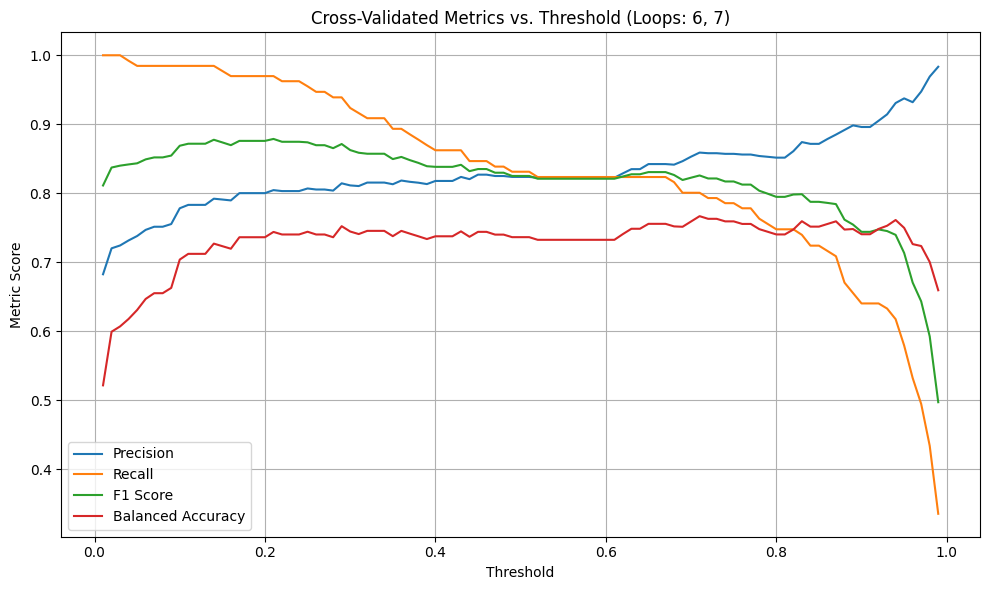

In [15]:

results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[6,7],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)


Fold 1 ROC AUC (loop 7): 0.963
Fold 1 ROC AUC (loop 8): 0.900
Fold 2 ROC AUC (loop 7): 0.967
Fold 2 ROC AUC (loop 8): 0.911
Fold 3 ROC AUC (loop 7): 0.833
Fold 3 ROC AUC (loop 8): 0.918
Fold 4 ROC AUC (loop 7): 0.952
Fold 4 ROC AUC (loop 8): 0.928
Fold 5 ROC AUC (loop 7): 0.866
Fold 5 ROC AUC (loop 8): 0.888

Average ROC AUC by loop:
  loop 7: 0.916 ± 0.056
  loop 8: 0.909 ± 0.014


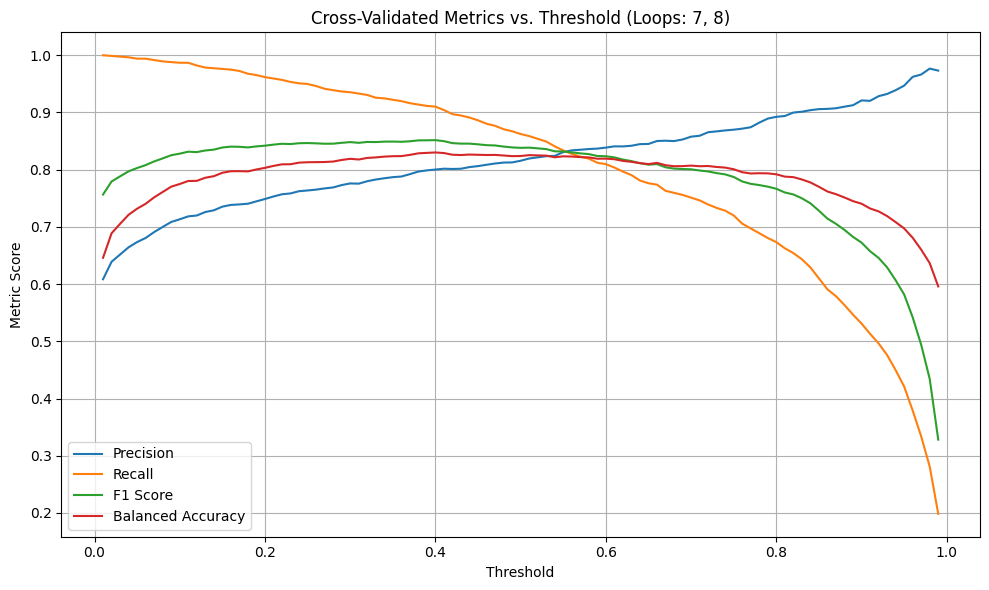

In [16]:

results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[7,8],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)


Fold 1 ROC AUC (loop 8): 0.904
Fold 1 ROC AUC (loop 9): 0.938
Fold 2 ROC AUC (loop 8): 0.932
Fold 2 ROC AUC (loop 9): 0.936
Fold 3 ROC AUC (loop 8): 0.917
Fold 3 ROC AUC (loop 9): 0.938
Fold 4 ROC AUC (loop 8): 0.944
Fold 4 ROC AUC (loop 9): 0.931
Fold 5 ROC AUC (loop 8): 0.926
Fold 5 ROC AUC (loop 9): 0.941

Average ROC AUC by loop:
  loop 8: 0.924 ± 0.013
  loop 9: 0.937 ± 0.003


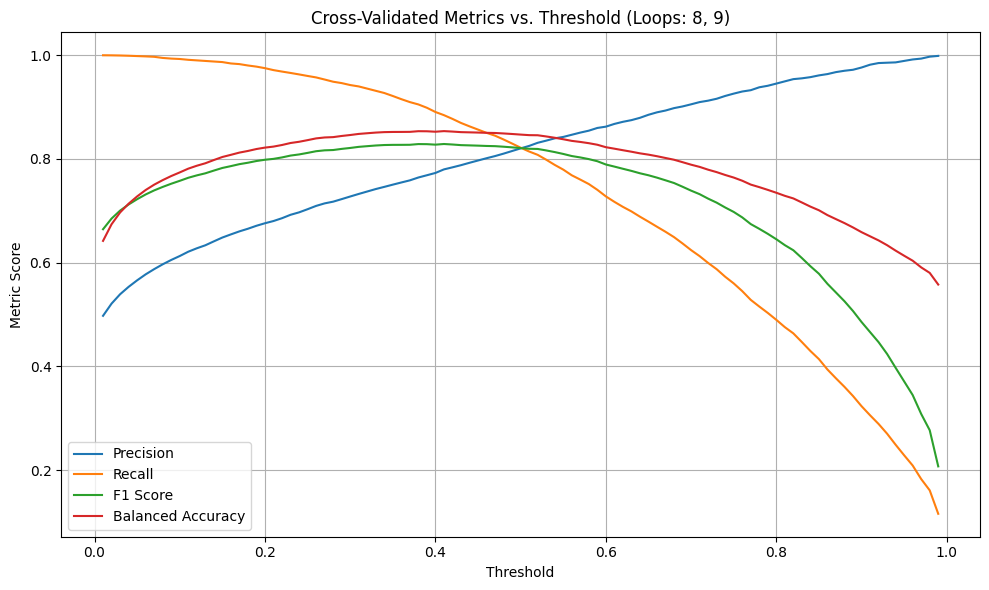

In [17]:
results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[8,9],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)

In [19]:
# directionality

In [18]:
from __future__ import annotations
from typing import Sequence, Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier


def train_test_loops_eval(
    df: pd.DataFrame,
    *,
    target_col: str = "COEFFICIENTS",
    loop_col: str = "loops",
    train_loops: Sequence[int] = (7,),
    test_loops: Sequence[int] = (8, 9, 10),
    feature_cols: Optional[Sequence[str]] = None,   # if None -> all except target/loop
    thresholds: Optional[np.ndarray] = None,        # if None -> linspace(0.01,0.99,99)
    model_kwargs: Optional[Dict[str, Any]] = None,  # passed to XGBClassifier
    random_state: int = 42,
    save_path: Optional[str] = None,                # path to save PNG; if None, don't save
):
    """
    Trains on rows with loop in train_loops, tests on rows with loop in test_loops.
    Reports per-loop ROC AUC on the test set and draws threshold curves on the *combined* test set.
    Works for any sizes of train/test loop sets.
    """
    if model_kwargs is None:
        model_kwargs = {}
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    # --- split data ---
    train_data = df[df[loop_col].isin(train_loops)].copy()
    test_data  = df[df[loop_col].isin(test_loops)].copy()
    if train_data.empty:
        raise ValueError("No rows match train_loops.")
    if test_data.empty:
        raise ValueError("No rows match test_loops.")

    # --- features ---
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in (target_col, loop_col)]

    X_train = train_data[feature_cols].to_numpy()
    y_train = train_data[target_col].to_numpy().ravel().astype(int)

    X_test  = test_data[feature_cols].to_numpy()
    y_test  = test_data[target_col].to_numpy().ravel().astype(int)
    loop_test = test_data[loop_col].to_numpy()

    # --- model ---
    model = XGBClassifier(eval_metric="logloss", random_state=random_state, **model_kwargs)
    model.fit(X_train, y_train)

    # --- scores ---
    test_scores = model.predict_proba(X_test)[:, 1]

    # per-test-loop AUCs
    per_loop_auc: Dict[int, float] = {}
    for loop_id in test_loops:
        mask = (loop_test == loop_id)
        if mask.any():
            y_true = y_test[mask]
            y_sc   = test_scores[mask]
            try:
                per_loop_auc[loop_id] = roc_auc_score(y_true, y_sc)
                print(f"AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")
            except ValueError:
                # happens if the subset has only one class
                per_loop_auc[loop_id] = np.nan
                print(f"AUC (loop {loop_id}): NaN (single-class subset)")
        else:
            print(f"No samples for loop {loop_id} in test set")

    # (optional) AUC on the training data for reference
    train_scores = model.predict_proba(X_train)[:, 1]
    try:
        train_auc = roc_auc_score(y_train, train_scores)
    except ValueError:
        train_auc = np.nan
    print(f"AUC (train loops {list(train_loops)}): {train_auc:.3f}" if train_auc == train_auc
          else f"AUC (train loops {list(train_loops)}): NaN (single-class)")

    # --- threshold sweep on combined test set ---
    thresholds = np.asarray(thresholds, dtype=float)
    precisions, recalls, f1s, bals = [], [], [], []
    for t in thresholds:
        y_pred = (test_scores >= t).astype(int)
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        bals.append(balanced_accuracy_score(y_test, y_pred))
    precisions = np.asarray(precisions)
    recalls    = np.asarray(recalls)
    f1s        = np.asarray(f1s)
    bals       = np.asarray(bals)

    # --- summary print ---
    print("\nSummary:")
    print(f"  Train AUC (loops {list(train_loops)}): {train_auc:.3f}" if train_auc == train_auc
          else f"  Train AUC (loops {list(train_loops)}): NaN (single-class)")
    for loop_id in test_loops:
        if loop_id in per_loop_auc:
            auc_val = per_loop_auc[loop_id]
            print(f"  Test AUC (loop {loop_id}): {auc_val:.3f}" if auc_val == auc_val
                  else f"  Test AUC (loop {loop_id}): NaN (single-class)")

    # --- plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, bals, label="Balanced Accuracy")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title(f"Train Loops: {list(train_loops)} | Test Loops: {list(test_loops)}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Saved plot to: {save_path}")
    plt.show()

    return {
        "model": model,
        "feature_cols": list(feature_cols),
        "thresholds": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": bals,
        "per_loop_auc": per_loop_auc,
        "train_auc": train_auc,
    }





AUC (loop 7): 0.812
AUC (train loops [6]): 1.000

Summary:
  Train AUC (loops [6]): 1.000
  Test AUC (loop 7): 0.812
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/6_7.png


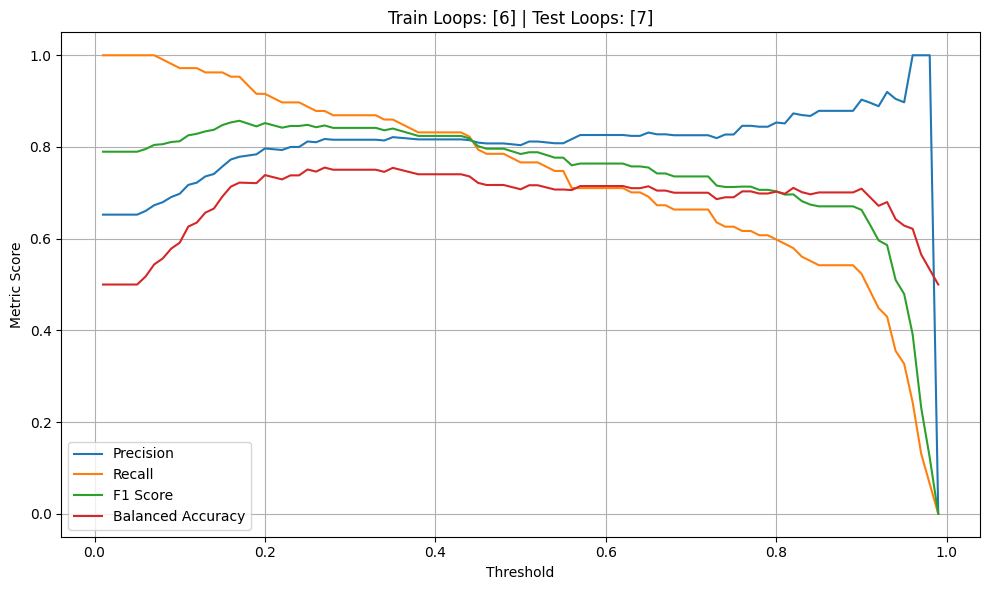

In [28]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[6],            # put ANY train loops here
    test_loops=[7],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=1000, max_depth=60, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/6_7.png",
)

AUC (loop 7): 0.822
AUC (train loops [5, 6]): 1.000

Summary:
  Train AUC (loops [5, 6]): 1.000
  Test AUC (loop 7): 0.822
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/56_789.png


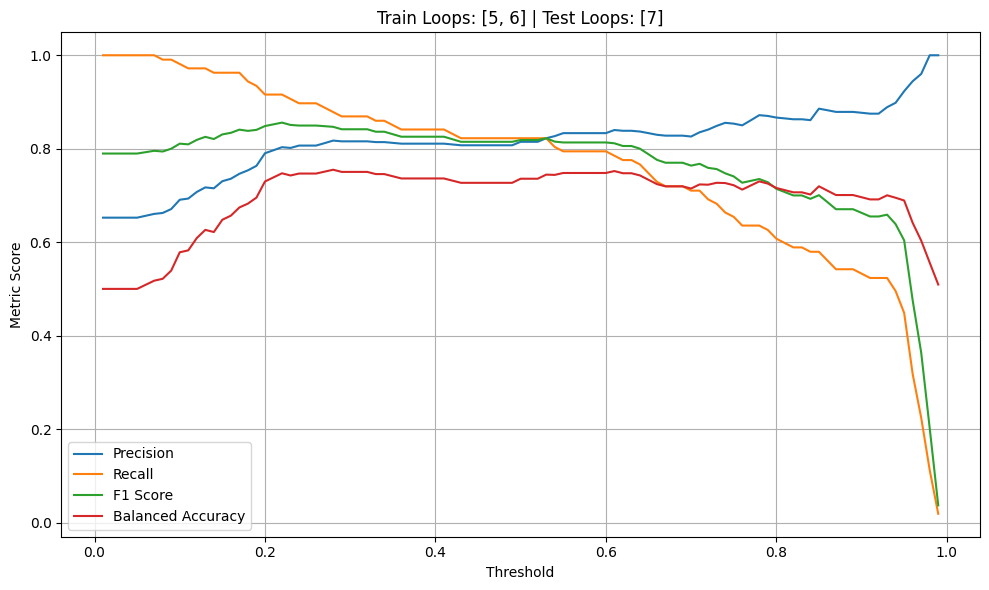

In [21]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6],            # put ANY train loops here
    test_loops=[7],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/56_789.png",
)

AUC (loop 8): 0.801
AUC (train loops [5, 6, 7]): 1.000

Summary:
  Train AUC (loops [5, 6, 7]): 1.000
  Test AUC (loop 8): 0.801
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/567_89.png


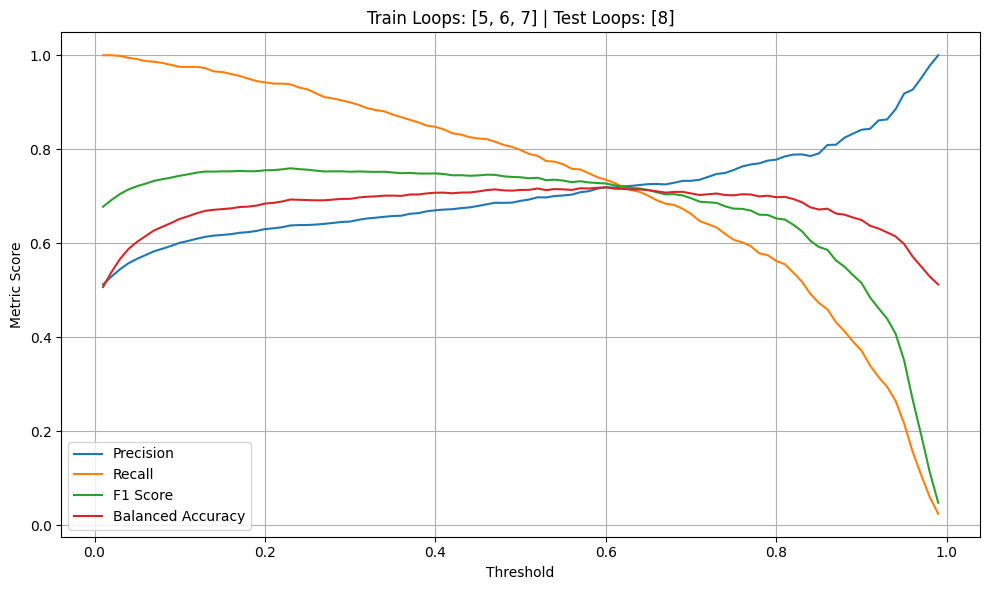

In [22]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6, 7],            # put ANY train loops here
    test_loops=[8],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/567_89.png",
)

AUC (loop 9): 0.834
AUC (train loops [5, 6, 7, 8]): 1.000

Summary:
  Train AUC (loops [5, 6, 7, 8]): 1.000
  Test AUC (loop 9): 0.834
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png


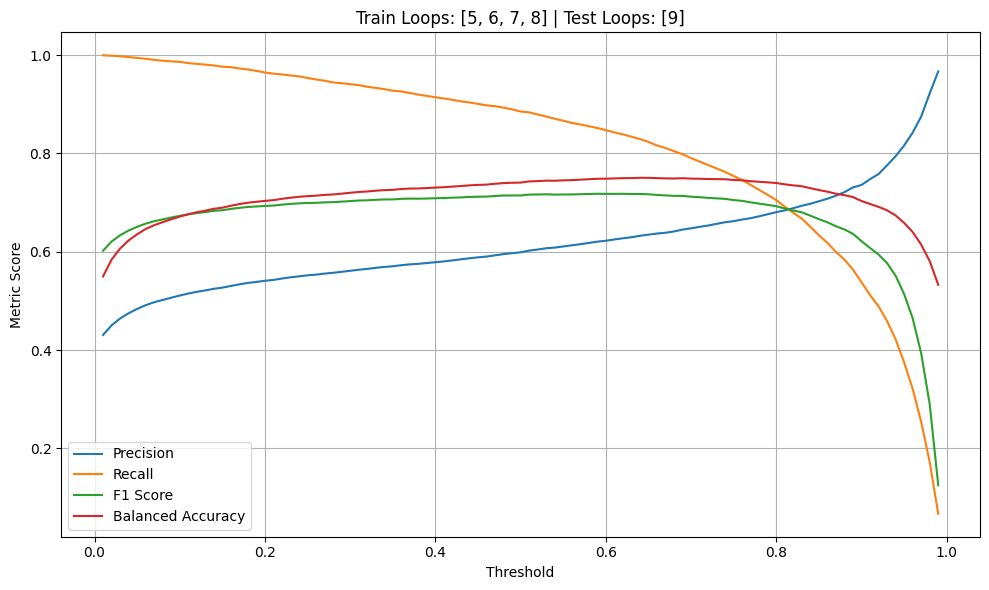

In [23]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6, 7, 8],            # put ANY train loops here
    test_loops=[9],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png",
)

AUC (loop 10): 0.870
AUC (train loops [5, 6, 7, 8, 9]): 0.998

Summary:
  Train AUC (loops [5, 6, 7, 8, 9]): 0.998
  Test AUC (loop 10): 0.870
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png


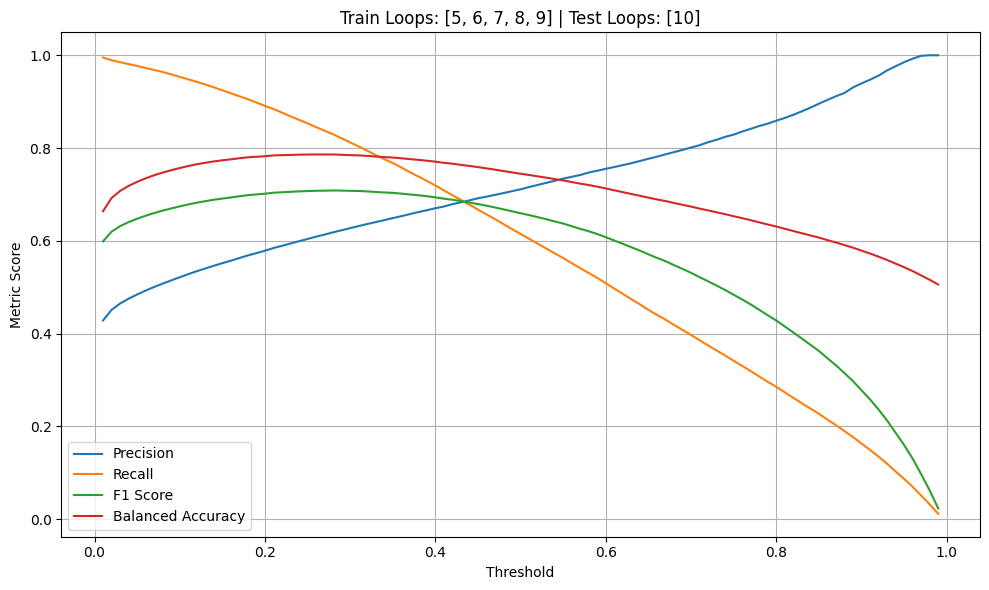

In [24]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6, 7, 8 , 9],            # put ANY train loops here
    test_loops=[10],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png",
)

In [ ]:
##### STOP HERE

In [20]:
##### STOP HERE

In [21]:
# cluster the data and let's see what preditive power we get

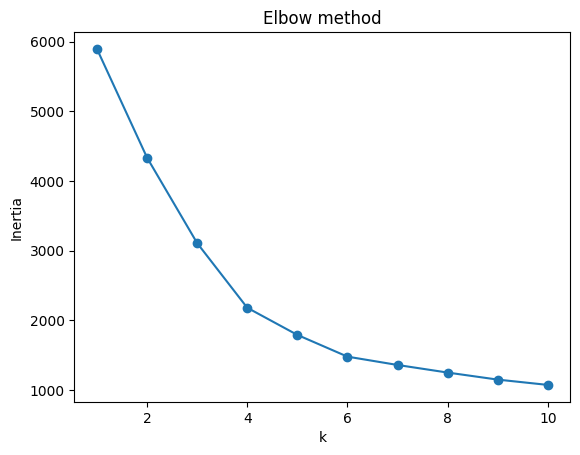

Suggested k = 4


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 7]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


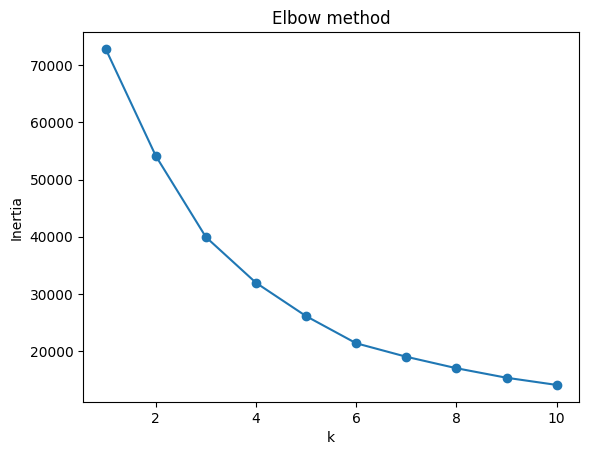

Suggested k = 3


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 8]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


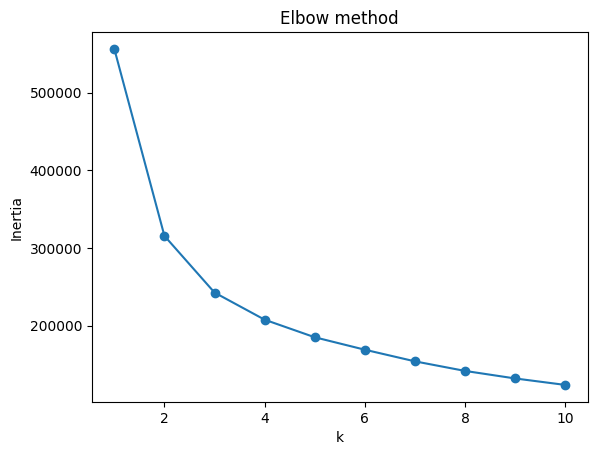

Suggested k = 2


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 9]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


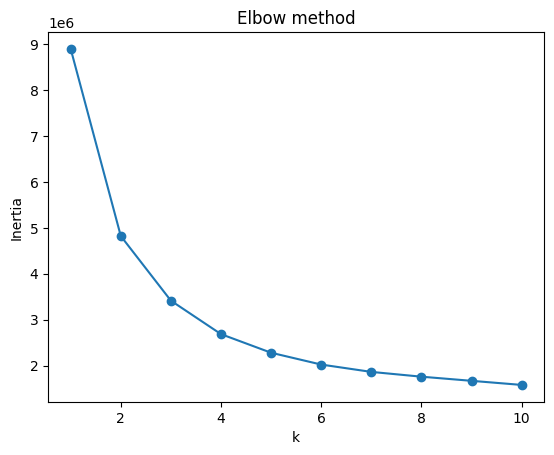

Suggested k = 2


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 10]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


In [26]:
# let's take 20

In [62]:
"""
Goal
----
Find which cluster (from the ten test loops) you should add to the
training data to maximise performance on the rest of the test set.
"""

import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------
train_loops  = [7, 8, 9]          # original train loops
test_loops   = list(range(1, 11)) # ten loops → will be clustered
random_state = 42
n_splits     = 5
n_clusters   = 20                 # exactly 10 clusters on the test set
# ------------------------------------------------------------

# ------------------  split data -----------------------------
train_df = all_loops[all_loops["loops"].isin(train_loops)].reset_index(drop=True)
test_df  = all_loops[all_loops["loops"].isin(test_loops )].reset_index(drop=True)

feature_cols = [c for c in all_loops.columns if c not in ("COEFFICIENTS", "loops")]
target_col   = "COEFFICIENTS"

X_train_base = train_df[feature_cols].values
y_train_base = train_df[target_col].values.ravel()

X_test_df    = test_df[feature_cols].copy()      # keep NaNs for XGB
y_test_full  = test_df[target_col].values.ravel()
loops_full   = test_df["loops"].values

# ------------------  cluster test set ----------------------
X_cluster = X_test_df.dropna(axis=1).values      # drop NaN columns for KMeans
kmeans    = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
clusters  = kmeans.fit_predict(X_cluster)

# ------------------  function: train & score ---------------
def train_and_score(X_train, y_train, X_test, y_test):
    """
    Train a fresh XGB (single fit, no CV) and return ROC-AUC on X_test.
    """
    model = XGBClassifier(eval_metric="logloss", random_state=random_state)
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    auc  = roc_auc_score(y_test, prob)
    return auc, prob

# ---------- main experiment (unchanged except for bookkeeping) ----------
results = []

for cl in range(n_clusters):
    in_clust  = clusters == cl
    out_clust = ~in_clust

    X_train = np.vstack([X_train_base, X_test_df[in_clust].values])
    y_train = np.concatenate([y_train_base, y_test_full[in_clust]])

    X_test  = X_test_df[out_clust].values
    y_test  = y_test_full[out_clust]
    loops   = loops_full[out_clust]

    auc, prob = train_and_score(X_train, y_train, X_test, y_test)

    results.append(
        dict(cluster=cl,
             added_rows=in_clust.sum(),
             remaining_rows=out_clust.sum(),
             final_train_rows=X_train.shape[0],
             final_test_rows=X_test.shape[0],
             overall_auc=auc,
             auc_by_loop={
                 lp: roc_auc_score(y_test[loops == lp], prob[loops == lp])
                 for lp in np.unique(loops)
             })
    )

# ------------------  report -------------------------------
print("\n=== PROMOTE-ONE-CLUSTER RESULTS ===")
for r in results:
    print(f"Cluster {r['cluster']:2d} | "
          f"rows→train {r['added_rows']:5d} | "
          f"remaining test {r['remaining_rows']:5d} | "
          f"AUC = {r['overall_auc']:.3f}")

best = max(results, key=lambda r: r["overall_auc"])

print(f"\n>>> Add cluster {best['cluster']} "
      f"→ best AUC {best['overall_auc']:.3f}")
print(f"Final TRAIN size = {best['final_train_rows']} rows")
print(f"Final TEST  size = {best['final_test_rows']} rows")

print("\nPer-loop AUC after adding that cluster:")
for lp, score in sorted(best["auc_by_loop"].items()):
    print(f"  Loop {lp:2d} · AUC = {score:.3f}")


=== PROMOTE-ONE-CLUSTER RESULTS ===
Cluster  0 | rows→train 21310 | remaining test 147510 | AUC = 0.889
Cluster  1 | rows→train  4927 | remaining test 163893 | AUC = 0.831
Cluster  2 | rows→train 12960 | remaining test 155860 | AUC = 0.864
Cluster  3 | rows→train  2294 | remaining test 166526 | AUC = 0.850
Cluster  4 | rows→train  1424 | remaining test 167396 | AUC = 0.852
Cluster  5 | rows→train 15156 | remaining test 153664 | AUC = 0.890
Cluster  6 | rows→train  2467 | remaining test 166353 | AUC = 0.849
Cluster  7 | rows→train 16574 | remaining test 152246 | AUC = 0.878
Cluster  8 | rows→train 21277 | remaining test 147543 | AUC = 0.890
Cluster  9 | rows→train   143 | remaining test 168677 | AUC = 0.834
Cluster 10 | rows→train  6077 | remaining test 162743 | AUC = 0.838
Cluster 11 | rows→train   654 | remaining test 168166 | AUC = 0.828
Cluster 12 | rows→train  2600 | remaining test 166220 | AUC = 0.871
Cluster 13 | rows→train  6539 | remaining test 162281 | AUC = 0.830
Cluster 14 

In [63]:
# ------------------------------------------------------------
# 1️⃣  First pass (unchanged) – pick the single best cluster
# ------------------------------------------------------------
first_pass = []

for cl in range(n_clusters):
    mask_in  = clusters == cl
    mask_out = ~mask_in

    X_train = np.vstack([X_train_base, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_base, y_test_full[mask_in]])

    auc, _  = train_and_score(X_train, y_train,
                              X_test_df[mask_out].values,
                              y_test_full[mask_out])

    first_pass.append((cl, auc))

best1, best1_auc = max(first_pass, key=lambda t: t[1])
print(f"▶ Best first cluster = {best1}  (AUC = {best1_auc:.3f})")

# ------------------------------------------------------------
# 2️⃣  Second pass – pick the best *additional* cluster
# ------------------------------------------------------------
mask_best1 = clusters == best1          # already promoted
X_train_lvl1 = np.vstack([X_train_base,
                          X_test_df[mask_best1].values])
y_train_lvl1 = np.concatenate([y_train_base,
                               y_test_full[mask_best1]])

second_pass = []

for cl in range(n_clusters):
    if cl == best1:
        continue                       # skip the one we already added

    mask_in  = (clusters == cl)
    mask_out = ~(mask_best1 | mask_in) # still-held-out data

    X_train = np.vstack([X_train_lvl1, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_lvl1, y_test_full[mask_in]])

    auc, _ = train_and_score(X_train, y_train,
                             X_test_df[mask_out].values,
                             y_test_full[mask_out])

    second_pass.append((cl, auc))

best2, best2_auc = max(second_pass, key=lambda t: t[1])

print("\n=== TWO-CLUSTER PROMOTION RESULT ===")
print(f"1st cluster promoted : {best1}")
print(f"2nd cluster promoted : {best2}")
print(f"AUC after two clusters: {best2_auc:.3f}")


▶ Best first cluster = 5  (AUC = 0.890)

=== TWO-CLUSTER PROMOTION RESULT ===
1st cluster promoted : 5
2nd cluster promoted : 8
AUC after two clusters: 0.908


In [64]:
# ------------------------------------------------------------
# Utility: return overall AUC after promoting a given set of clusters
# ------------------------------------------------------------
def auc_with_clusters(promoted):
    """
    promoted : iterable of cluster IDs already moved to the train fold
    """
    promoted_mask = np.isin(clusters, promoted)

    X_train = np.vstack([X_train_base, X_test_df[promoted_mask].values])
    y_train = np.concatenate([y_train_base, y_test_full[promoted_mask]])

    X_hold  = X_test_df[~promoted_mask].values
    y_hold  = y_test_full[~promoted_mask]

    auc, _ = train_and_score(X_train, y_train, X_hold, y_hold)
    return auc

# ------------------------------------------------------------
# We already have best1 and best2 from the earlier passes
# ------------------------------------------------------------
selected = [best1, best2]
current_auc = auc_with_clusters(selected)
print(f"AUC after clusters {selected}: {current_auc:.3f}")

# ------------------------------------------------------------
# 3️⃣  Third pass – pick the next best cluster
# ------------------------------------------------------------
candidates = [c for c in range(n_clusters) if c not in selected]

improvements = []
for c in candidates:
    auc_c = auc_with_clusters(selected + [c])
    improvements.append((c, auc_c))

best3, best3_auc = max(improvements, key=lambda t: t[1])
selected.append(best3)

print("\n=== THREE-CLUSTER PROMOTION RESULT ===")
print(f"Clusters promoted : {selected}")
print(f"AUC after three clusters: {best3_auc:.3f}")


AUC after clusters [5, 8]: 0.907

=== THREE-CLUSTER PROMOTION RESULT ===
Clusters promoted : [5, 8, 19]
AUC after three clusters: 0.917


In [67]:
np.sum([c in [5, 8, 19] for c in clusters])

np.int64(50783)

In [31]:
(all_loops[all_loops['loops'] == 9].shape[0]/5)*4

11177.6

In [72]:
len(all_loops[all_loops['loops'] == 10])*0.8

122601.6

In [33]:
#loops 7,8,9 and lesser parts of 10 would be helpful in scoring 10 better than others.

In [34]:
# what coefficients of 10 are hard to find using cusp relation or switch when using each method?

In [35]:
pd.Series(clusters).value_counts().sort_index()

0     1336
1      568
2     1905
3       66
4     1702
5      435
6     1116
7     1629
8       97
9     1294
10     696
11     336
12     535
13       7
14       1
15      98
16    1843
17     165
18    1256
19     483
Name: count, dtype: int64

Fold 1 ROC AUC: 0.906
Fold 2 ROC AUC: 0.908
Fold 3 ROC AUC: 0.906

Average ROC AUC: 0.907 ± 0.001


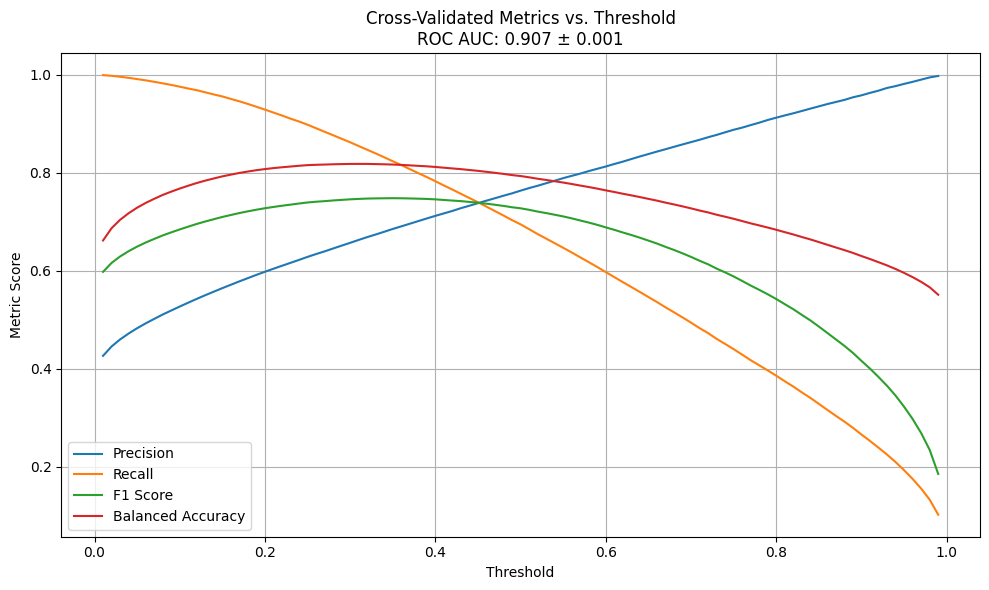

In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop10_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)
splits = 3

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_test, X_train = X[train_idx], X[test_idx]
    y_test, y_train = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
